# Loading & Libararies

In [1]:
ls

drive/  sample_data/


In [2]:
cd /content/drive/MyDrive/Master/code_base/dataset/single_classification

/content/drive/MyDrive/Master/code_base/dataset/single_classification


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
import cv2
import torch.onnx
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import torch
import torchvision
from PIL import Image, ImageEnhance
from torchvision import datasets
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
#Define the directories\
data_dir = '/content/drive/MyDrive/Master/code_base/dataset/single_classification'
dir_stained = "/content/drive/MyDrive/Master/code_base/dataset/single_classification/stained"
dir_defect_free = "/content/drive/MyDrive/Master/code_base/dataset/single_classification/stain_free"

In [5]:

dir_stained = os.path.join(data_dir, "stained")
dir_defect_free = os.path.join(data_dir, "stain_free")

print("Number of Stained images:", len(os.listdir(dir_stained)))
print("Number of Stain Free images:", len(os.listdir(dir_defect_free)))

Number of Stained images: 468
Number of Stain Free images: 77


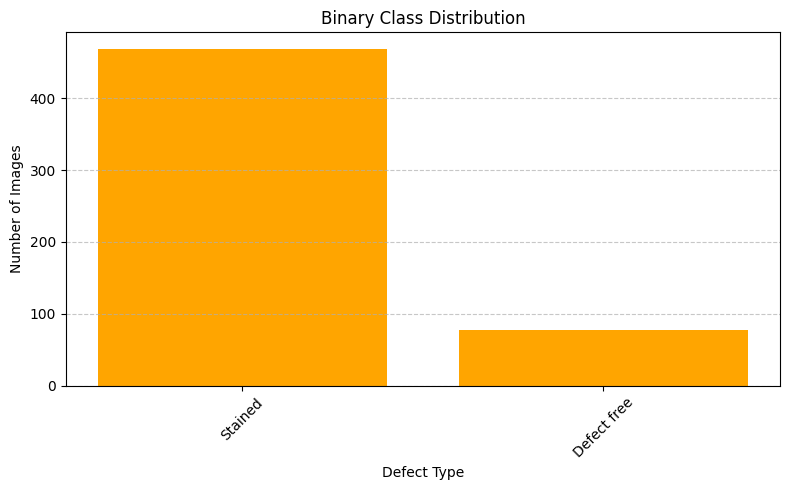

In [6]:
classes = {
    "Stained": os.path.join(data_dir, "stained"),
    "Defect free": os.path.join(data_dir, "stain_free")
}

# Count images in each class
image_counts = {label: len(os.listdir(path)) for label, path in classes.items()}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(image_counts.keys(), image_counts.values(), color='orange')
plt.title('Binary Class Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Understanding the dataset

## Vizuallize the Images

Stained Images:


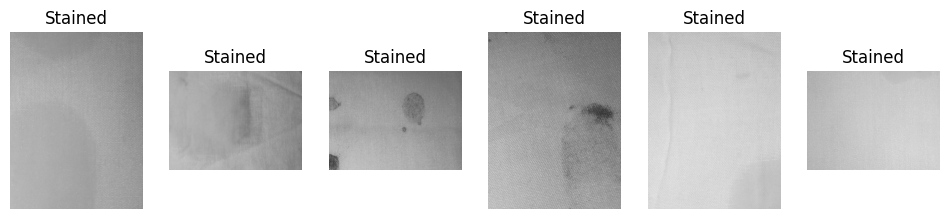

Defect Free Images:


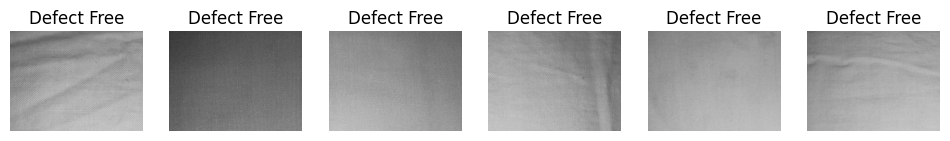

In [7]:
# Load the file names from both directories
stained = os.listdir(dir_stained)
defect_free = os.listdir(dir_defect_free)

# Function to display images
def display_images(image_list, image_dir, label, num_images=6):
    plt.figure(figsize=(12, 6))
    for i, image_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis('off')
    plt.show()

#Display Images
print("Stained Images:")
display_images(stained, dir_stained, label="Stained")


print("Defect Free Images:")
display_images(defect_free, dir_defect_free, label="Defect Free")

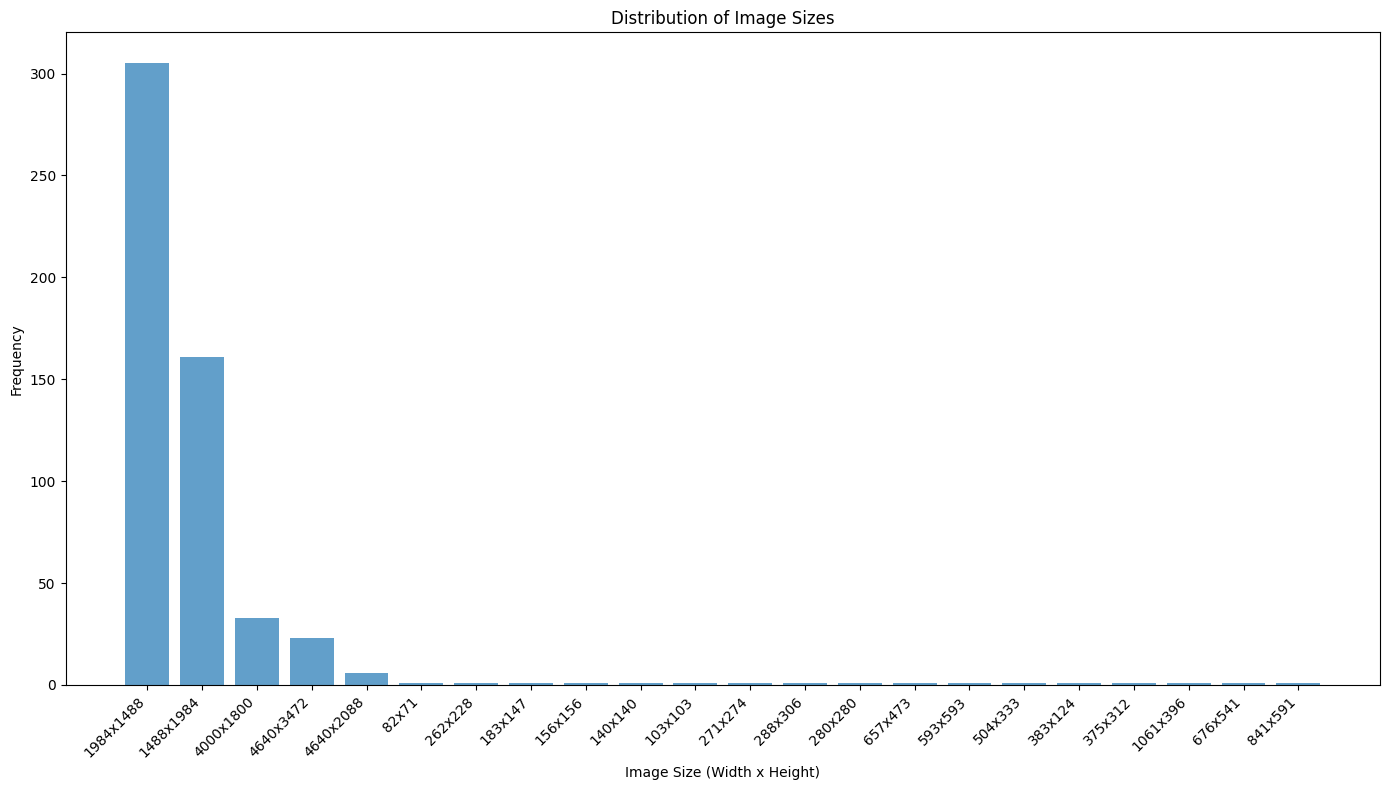

In [8]:

# Combine image paths from multiple folders
def get_image_paths(folders):
    image_paths = []
    for folder in folders:
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_paths.append(file_path)
    return image_paths

# Collect image size information
def collect_image_sizes(image_paths):
    image_sizes = []
    for image_path in image_paths:
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))
    return image_sizes

# Display the distribution of each image size
def display_image_size_distribution(image_sizes):
    # Convert list of tuples to DataFrame
    df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

    # Count occurrences of each unique size
    size_counts = df.value_counts().reset_index(name='Count')
    size_counts.rename(columns={0: 'Count'}, inplace=True)

    # Plot the distribution
    plt.figure(figsize=(14, 8))
    plt.bar(
        size_counts.index,
        size_counts['Count'],
        tick_label=[f"{w}x{h}" for w, h in size_counts[['Width', 'Height']].values],
        alpha=0.7
    )
    plt.xlabel("Image Size (Width x Height)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Sizes")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

# Example usage
folders = [dir_stained, dir_defect_free]  # Use your defined folder paths
image_paths = get_image_paths(folders)
image_sizes = collect_image_sizes(image_paths)
display_image_size_distribution(image_sizes)


# Data Cleaning

### Stratified Split

In [9]:
dataset = datasets.ImageFolder(root=data_dir)

# Extract labels for stratified splitting
labels = [label for _, label in dataset.samples]

# Stratified split into train (70%) and temp (30%)
train_indices, temp_indices = train_test_split(
    np.arange(len(labels)),
    test_size=0.30,
    stratify=labels,
    random_state=42
)

# Stratified split of temp into validation (15%) and test (15%)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.50,
    stratify=[labels[i] for i in temp_indices],
    random_state=42
)

# Create subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Verify class distributions
train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]

print("Train class distribution:", {label: train_labels.count(label) for label in set(train_labels)})
print("Validation class distribution:", {label: val_labels.count(label) for label in set(val_labels)})
print("Test class distribution:", {label: test_labels.count(label) for label in set(test_labels)})

# Class 0: Defect Free
# Class 1: Defective

Train class distribution: {0: 54, 1: 327}
Validation class distribution: {0: 12, 1: 70}
Test class distribution: {0: 11, 1: 71}


In [10]:
print(len(train_dataset))

381


### Transform

In [11]:
# Define transformations for train sets
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),       # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Define transformations for validation/test sets
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),       # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# custom dataset wrapper to apply the different transformations on the respective splits
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]  # Get the image and label
        if self.transform:
            image = self.transform(image)  # Apply the transformation
        return image, label



In [12]:
# Apply transformations to the datasets
train_dataset = TransformedDataset(train_dataset, transform=train_transform)
val_dataset = TransformedDataset(val_dataset, transform=val_test_transform)
test_dataset = TransformedDataset(test_dataset, transform=val_test_transform)

# Define the DataLoaders for each set
batch_size = 32 # 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ['Defect_free', 'Stained']

#Vizuallize the loaders

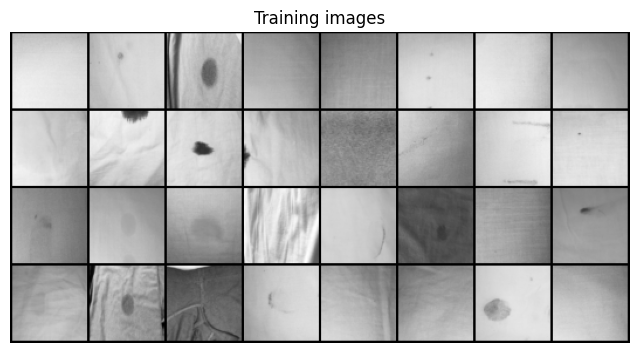

In [13]:
train_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(train_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

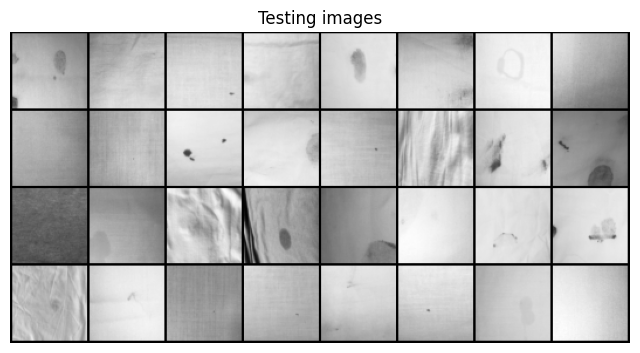

In [14]:
test_batch = next(iter(test_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Testing images")
plt.imshow(
    np.transpose(
        vutils.make_grid(test_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

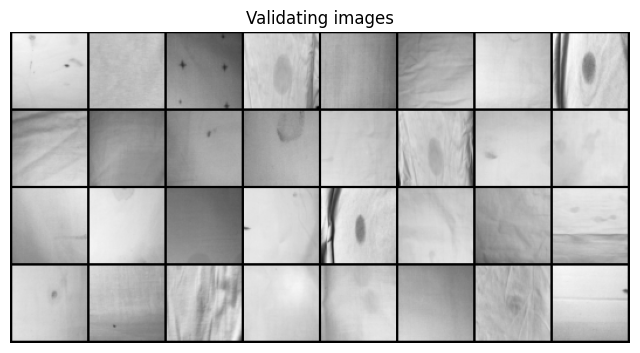

In [15]:
valid_batch = next(iter(valid_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validating images")
plt.imshow(
    np.transpose(
        vutils.make_grid(valid_batch[0][:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

## Vizuallize the distribution

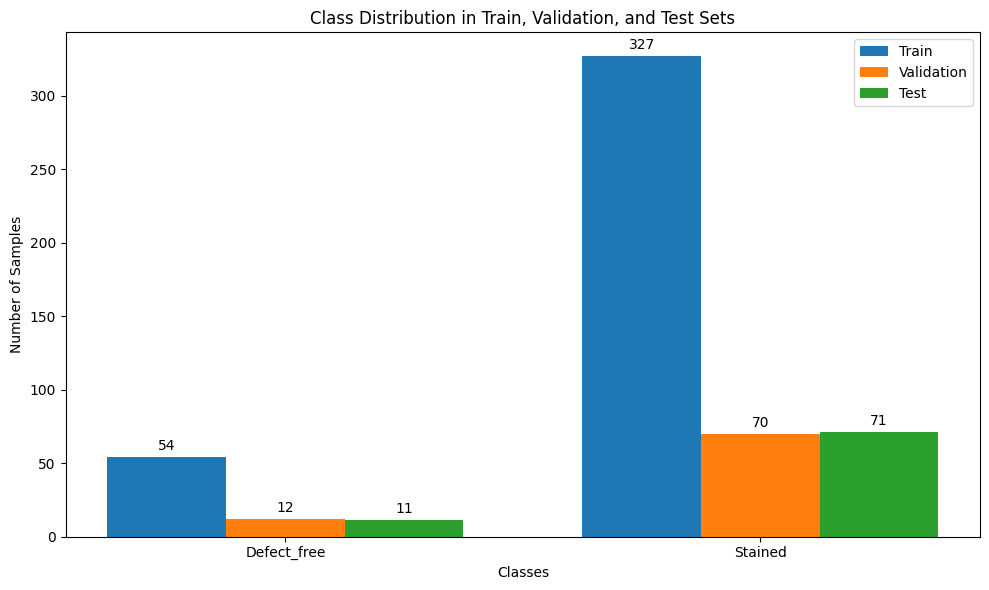

In [16]:

def get_class_distribution(loader):
    """Helper function to get the class distribution from a DataLoader."""
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.numpy())  # Update counter with the labels
    return class_counts

def plot_class_distribution(train_loader, valid_loader, test_loader, class_names = ['Defect_free', 'Stained']):
    """Plot the class distribution for each dataset."""

    # Get class distributions from each loader
    train_counts = get_class_distribution(train_loader)
    valid_counts = get_class_distribution(valid_loader)
    test_counts = get_class_distribution(test_loader)

    # Convert counters to lists of class counts
    train_counts_list = [train_counts[i] for i in range(len(class_names))]
    valid_counts_list = [valid_counts[i] for i in range(len(class_names))]
    test_counts_list = [test_counts[i] for i in range(len(class_names))]

    # Plot the class distributions
    labels = class_names
    x = np.arange(len(labels))  # Label locations

    width = 0.25  # Width of the bars
    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width, train_counts_list, width, label='Train')
    rects2 = ax.bar(x, valid_counts_list, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts_list, width, label='Test')

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution in Train, Validation, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar, displaying its height
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.tight_layout()
    plt.show()

# Visualize the class balances in each DataLoader
plot_class_distribution(train_loader, valid_loader, test_loader, class_names=['Defect_free', 'Stained'])


# Models

## Initial CNN Model

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Placeholder for the fully connected layer
        self.fc1 = None
        self.fc2 = nn.Linear(512, 2)  # 2 classes: Infected and Uninfected

    def forward(self, x):
        # Convolutional Layers with ReLU and Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Dynamically calculate the flattened size based on input size
        if self.fc1 is None:
            # Calculate the size after the convolutional layers
            flattened_size = x.view(x.size(0), -1).size(1)
            # Initialize the fully connected layer with the correct size
            self.fc1 = nn.Linear(flattened_size, 512)
            # Move the layer to the same device as the model
            self.fc1.to(x.device)

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully Connected Layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model_intial_model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_intial_model.to(device)
print(model_intial_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [18]:
criterion_intial_model = nn.CrossEntropyLoss()
optimizer_intial_model = optim.Adam(model_intial_model.parameters(), lr=0.001)

### Model Export

In [19]:
# sample_input, _ = next(iter(train_loader))

# # Use only one sample or the entire batch depending on your use case
# sample_input = sample_input.to(device)
# onnx_file_path = "cnn_model.onnx"
# # Run the model once to initialize dynamic layers
# model(sample_input)

# # Export to ONNX using the sample_input
# torch.onnx.export(
#     model,
#     sample_input,  # Use real data instead of random tensor
#     onnx_file_path,
#     export_params=True,
#     opset_version=11,
#     do_constant_folding=True,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"✅ Model exported to: {os.path.abspath(onnx_file_path)}")

## Improved CNN Model

In [20]:

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.5)

        # Global Average Pooling Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)  # Binary classification

        # Weight initialization
        self._init_weights()

    def forward(self, x):
        # Block 1
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = self.dropout1(x)

        # Block 2
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.dropout2(x)

        # Block 3
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)
        x = self.dropout3(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        # Fully Connected Layers
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x

    def _init_weights(self):
        # He Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)


# Instantiate the model
model_improved = ImprovedCNN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_improved.to(device)

# Print the model architecture
print(model_improved)


ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [21]:
# Define class weights
class_weights_improved_model = torch.tensor([3.5, 0.5], dtype=torch.float).to(device)

# Define the loss function with class weights
criterion_improved_model = nn.CrossEntropyLoss(weight=class_weights_improved_model)

# Define the optimizer
optimizer_improved_model = torch.optim.Adam(model_improved.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization added


### Model Export

In [22]:
# sample_input_new, _ = next(iter(train_loader))

# # Use only one sample or the entire batch depending on your use case
# sample_input = sample_input.to(device)
# onnx_file_path = "i_cnn_model.onnx"
# # Run the model once to initialize dynamic layers
# new_model(sample_input_new)

# # Export to ONNX using the sample_input
# torch.onnx.export(
#     new_model,
#     sample_input_new,  # Use real data instead of random tensor
#     onnx_file_path,
#     export_params=True,
#     opset_version=11,
#     do_constant_folding=True,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"✅ Model exported to: {os.path.abspath(onnx_file_path)}")

## Transfer Learning - EfficientNet_B0




In [23]:
def efficientnet_model(num_classes):
    model = models.efficientnet_b0(pretrained=True)

    # Modify the input conv layer to accept 1 channel (grayscale)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)  # e.g., 2 for Defect_free, Stained

model_efficient = efficientnet_model(num_classes)
model_efficient.to(device)
print(model_efficient)
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = torch.optim.Adam(model_efficient .parameters(), lr=1e-4)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Efficient Fine Tuned

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ------------------------------
# 1. EfficientNet Fine-tuning Model
# ------------------------------
def efficientnet_model_finetune(num_classes=2, unfreeze_from_block=4):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Adapt to grayscale input
    model.features[0][0] = nn.Conv2d(
        in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False
    )

    # Freeze all layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Unfreeze from selected block
    for name, module in model.features.named_children():
        if int(name) >= unfreeze_from_block:
            for param in module.parameters():
                param.requires_grad = True

    # Replace classification head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )

    return model

# ------------------------------
# 2. Prediction with Lowered Threshold
# ------------------------------
def predict_with_threshold(model, input_tensor, threshold=0.40):  # lowered threshold
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        if probs.shape[1] == 2:
            return (probs[:, 1] >= threshold).long()
        else:
            return torch.argmax(probs, dim=1)

# ------------------------------
# 3. Training Setup
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# Initialize the model
model_efficient_tuned = efficientnet_model_finetune(num_classes=num_classes)
model_efficient_tuned.to(device)

# Extract class distribution from train_loader
y_train = []
for _, labels in train_loader:
    y_train.extend(labels.cpu().numpy())

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=np.array(y_train)
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use CrossEntropyLoss with class weights
criterion_efficient_tuned = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer_efficient_tuned = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_efficient_tuned.parameters()),
    lr=1e-4
)

# Learning Rate Scheduler
scheduler_efficient_tuned = ReduceLROnPlateau(
    optimizer_efficient_tuned,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## **Transfer** Learning - Resnet 18

In [26]:
def build_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)

    # Modify first conv layer to accept 1-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Replace classifier (fc)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(classes)  # e.g., 2 for Defect_free, Stained


model_resnet = build_resnet18_model(num_classes)
model_resnet.to(device)
print(model_resnet)

# Optimizer and Loss
criterion_restnet = nn.CrossEntropyLoss()
optimizer_restnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Model Testing with Grad CAM Viz

## Train Validation Function

In [28]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._clear_hooks()
        self._register_hooks()

    def _clear_hooks(self):
        if hasattr(self.target_layer, '_backward_hooks'):
            self.target_layer._backward_hooks.clear()
        if hasattr(self.target_layer, '_full_backward_hooks'):
            self.target_layer._full_backward_hooks.clear()
        if hasattr(self.target_layer, '_forward_hooks'):
            self.target_layer._forward_hooks.clear()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_full_backward_hook(backward_hook)
        self.hook_handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.squeeze(0).cpu().numpy()

def get_gradcam_overlay(img_tensor, cam, cmap=cv2.COLORMAP_JET, alpha=0.5):
    # Convert tensor to NumPy array (H x W x C)
    img = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img = np.uint8(255 * img)
    # Convert grayscale to 3 channels if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Resize the CAM to match image size
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    # Apply colormap and convert to RGB
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    # Blend heatmap with original image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).to(tensor.device)
    std = torch.tensor(std).to(tensor.device)
    if tensor.ndim == 4:
        mean = mean.view(1, -1, 1, 1)
        std = std.view(1, -1, 1, 1)
    else:
        mean = mean.view(-1, 1, 1)
        std = std.view(-1, 1, 1)
    return tensor * std + mean

# ----------------- Training Function -----------------

def train_model_with_metrics_tqdm(model, train_loader, valid_loader, criterion, optimizer,scheduler=None, num_epochs=15, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_precisions, train_recalls, train_f1s = [], [], []
    valid_precisions, valid_recalls, valid_f1s = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        all_train_labels, all_train_preds = [], []

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total_train += batch_size
            correct_train += (predicted == labels).sum().item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

            avg_loss = running_loss / total_train
            avg_acc = 100 * correct_train / total_train
            train_bar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{avg_acc:.2f}%")

        train_loss = running_loss / total_train
        train_accuracy = 100 * correct_train / total_train
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        model.eval()
        valid_loss, correct_valid, total_valid = 0.0, 0, 0
        all_valid_labels, all_valid_preds = [], []

        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        with torch.no_grad():
            for images, labels in valid_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                batch_size = images.size(0)
                valid_loss += loss.item() * batch_size

                _, predicted = torch.max(outputs, 1)
                total_valid += batch_size
                correct_valid += (predicted == labels).sum().item()

                all_valid_labels.extend(labels.cpu().numpy())
                all_valid_preds.extend(predicted.cpu().numpy())

                avg_val_loss = valid_loss / total_valid
                avg_val_acc = 100 * correct_valid / total_valid
                valid_bar.set_postfix(loss=f"{avg_val_loss:.4f}", acc=f"{avg_val_acc:.2f}%")

        valid_loss = valid_loss / total_valid
        valid_accuracy = 100 * correct_valid / total_valid
        valid_precision = precision_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)
        valid_recall = recall_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)
        valid_f1 = f1_score(all_valid_labels, all_valid_preds, average='weighted', zero_division=0)

        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_precisions.append(valid_precision)
        valid_recalls.append(valid_recall)
        valid_f1s.append(valid_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'  Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'  Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%, Precision: {valid_precision:.2f}, Recall: {valid_recall:.2f}, F1: {valid_f1:.2f}')
        print('-' * 80)

        if scheduler is not None:
            scheduler.step(valid_loss)

        if (epoch + 1) % 5 == 0:
            try:
                if hasattr(train_loader.dataset, 'dataset') and hasattr(train_loader.dataset.dataset, 'classes'):
                    class_names = train_loader.dataset.dataset.classes
                elif hasattr(train_loader.dataset, 'classes'):
                    class_names = train_loader.dataset.classes
                else:
                    raise AttributeError
                num_classes = len(class_names)
            except AttributeError:
                class_names = ['Defect_free', 'Stained']
                num_classes = len(class_names)

            model.eval()
            images_by_class = [[] for _ in range(num_classes)]
            for images, labels in valid_loader:
                for i in range(images.size(0)):
                    cls = labels[i].item()
                    images_by_class[cls].append(images[i:i+1].to(device))
            random_images_by_class = [random.choice(cls_list) if cls_list else None for cls_list in images_by_class]

            fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))

            if num_classes == 1:
                axes = [axes]
            mean_vals = [0.485, 0.456, 0.406]
            std_vals = [0.229, 0.224, 0.225]
            for idx, sample_img in enumerate(random_images_by_class):
                if sample_img is not None:
                    sample_img_denorm = denormalize(sample_img.clone(), mean_vals, std_vals)
                    np_img = sample_img_denorm.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                    np_img = np.clip(np_img, 0, 1)
                    axes[idx].imshow(np_img)
                    axes[idx].set_title(f"Input - {class_names[idx]}")
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()

            if hasattr(model, 'conv3'):
                target_layer = model.conv3
            else:
                conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
                target_layer = conv_layers[-1]

            gradcam = GradCAM(model, target_layer)
            fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
            if num_classes == 1:
                axes = [axes]
            for cls_idx, sample_img in enumerate(random_images_by_class):
                if sample_img is not None:
                    cam = gradcam(sample_img)
                    overlay = get_gradcam_overlay(sample_img, cam)
                    axes[cls_idx].imshow(overlay)
                    axes[cls_idx].set_title(f"Grad-CAM - {class_names[cls_idx]}")
                    axes[cls_idx].axis('off')
            plt.tight_layout()
            plt.show()
            gradcam.remove_hooks()

    # Plotting
    def plot_metric(metric, name, ylabel):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), metric[0], label='Train', color='blue')
        plt.plot(range(1, num_epochs + 1), metric[1], label='Validation', color='green')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(f'Training and Validation {ylabel}')
        plt.legend()
        plt.show()

    plot_metric((train_losses, valid_losses), 'Loss', 'Loss')
    plot_metric((train_accuracies, valid_accuracies), 'Accuracy', 'Accuracy (%)')
    plot_metric((train_precisions, valid_precisions), 'Precision', 'Precision')
    plot_metric((train_recalls, valid_recalls), 'Recall', 'Recall')
    plot_metric((train_f1s, valid_f1s), 'F1 Score', 'F1 Score')


## Test Validation Function

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_multiple_models_with_gradcam(models, model_names, test_loader, class_names, device="cuda" if torch.cuda.is_available() else "cpu", num_samples=5):
    assert len(models) == len(model_names), "Mismatch between models and names"

    # Sample for Grad-CAM
    sample_images, sample_labels = [], []
    for images, labels in test_loader:
        for i in range(images.size(0)):
            sample_images.append(images[i:i+1])
            sample_labels.append(labels[i].item())
            if len(sample_images) >= num_samples:
                break
        if len(sample_images) >= num_samples:
            break

    for model, name in zip(models, model_names):
        model.to(device)
        model.eval()

        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Classification Metrics
        acc = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"\n Results for: {name}")
        print(f"   Accuracy  : {acc:.2f}%")
        print(f"   Precision : {precision:.4f}")
        print(f"   Recall    : {recall:.4f}")
        print(f"   F1 Score  : {f1:.4f}")
        print("   Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        # Grad-CAM Setup
        print(f"\n Grad-CAM Visualizations for {name}")
        if hasattr(model, 'conv3'):
            target_layer = model.conv3
        else:
            conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
            target_layer = conv_layers[-1]

        gradcam = GradCAM(model, target_layer)
        fig, axes = plt.subplots(2, num_samples, figsize=(5 * num_samples, 10))

        for i in range(num_samples):
            input_img = sample_images[i].to(device)
            true_label = class_names[sample_labels[i]]

            with torch.no_grad():
                output = model(input_img)
                pred_idx = output.argmax(dim=1).item()
                pred_label = class_names[pred_idx]

            # Generate Grad-CAM
            cam = gradcam(input_img, target_class=pred_idx)


            # Prepare overlay
            cam_resized = Image.fromarray(np.uint8(cam * 255)).resize((64, 64), resample=Image.BILINEAR)
            overlay = cam_resized

            # Convert grayscale image to numpy
            np_img = input_img.squeeze().cpu().numpy()

            # Plot original
            axes[0, i].imshow(np_img, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f"Original\nTrue: {true_label}", fontsize=10)

            # Plot Grad-CAM
            axes[1, i].imshow(np_img, cmap='gray')
            axes[1, i].imshow(overlay, cmap='jet', alpha=0.5)
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Grad-CAM\nPred: {pred_label}", fontsize=10)

        plt.suptitle(f"Grad-CAM and Input Visualization for {name}", fontsize=14)
        plt.tight_layout()
        plt.show()
        gradcam.remove_hooks()


# Test Results

## Initial Model

Epoch [1/15]:
  Training Loss: 0.5171, Accuracy: 83.99%, Precision: 0.76, Recall: 0.84, F1: 0.79
  Validation Loss: 0.4207, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [2/15]:
  Training Loss: 0.4099, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3927, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [3/15]:
  Training Loss: 0.4044, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3922, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [4/15]:
  Training Loss: 0.4006, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3905, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [5/15]:
  Training Loss: 0.3949, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3943, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


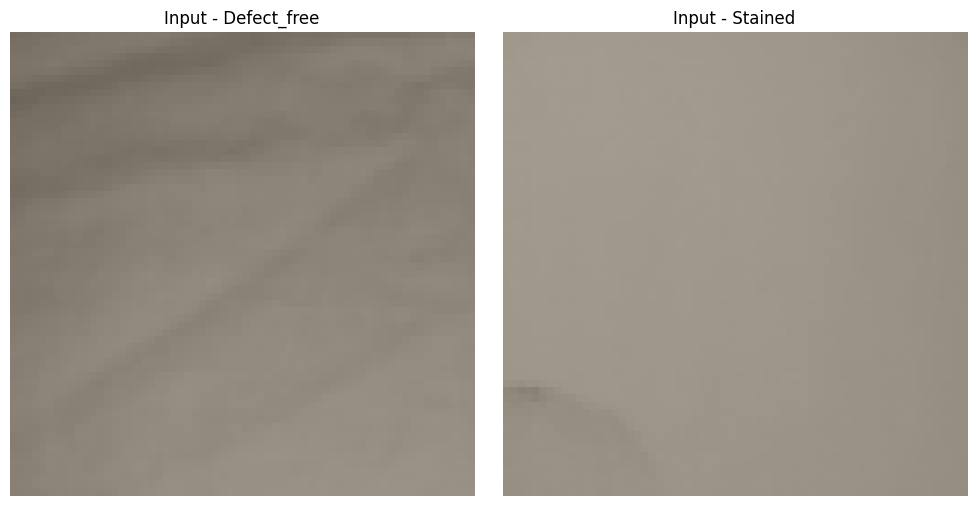

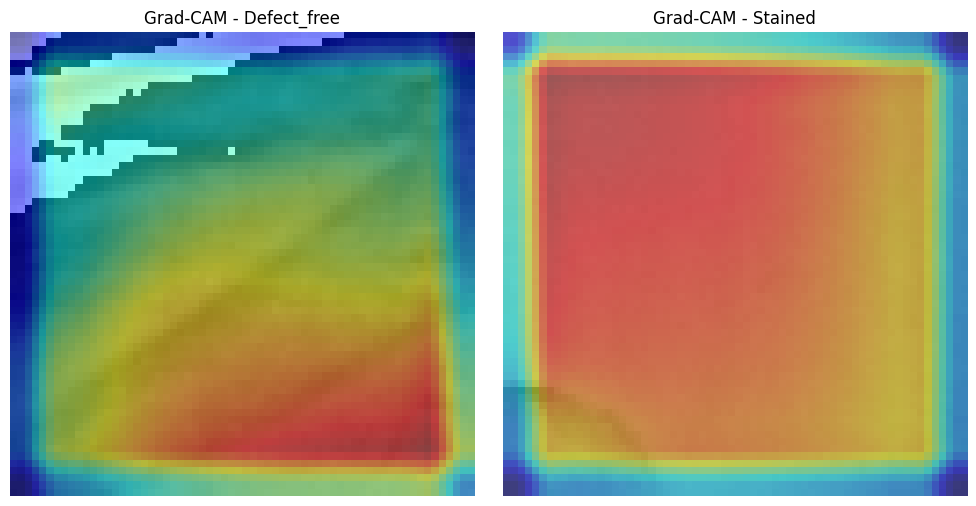

Epoch [6/15]:
  Training Loss: 0.3951, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3926, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [7/15]:
  Training Loss: 0.4014, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3988, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [8/15]:
  Training Loss: 0.4017, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3843, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [9/15]:
  Training Loss: 0.3913, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3840, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [10/15]:
  Training Loss: 0.3985, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3919, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


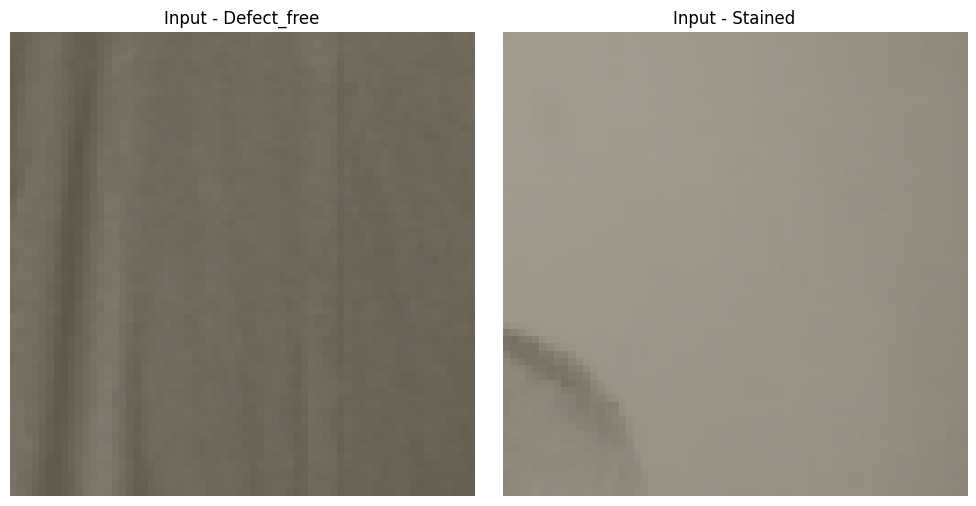

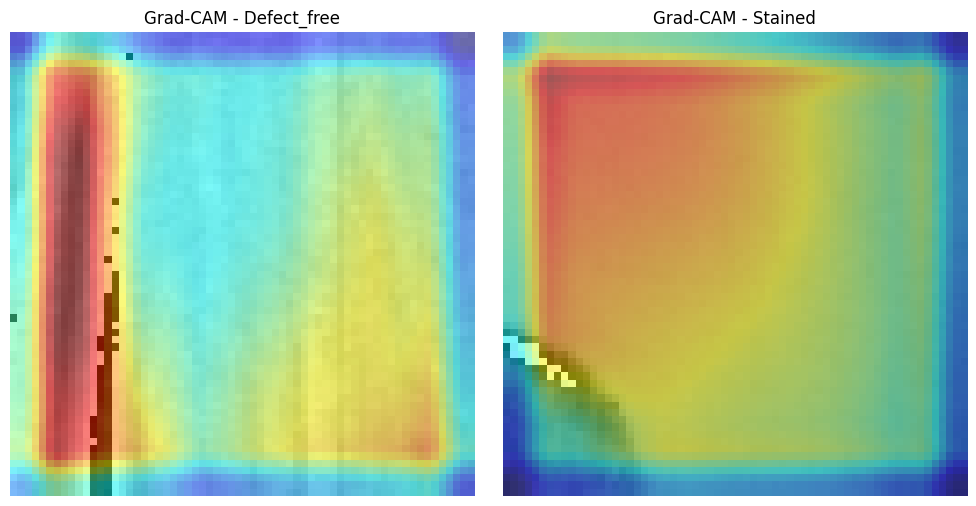

Epoch [11/15]:
  Training Loss: 0.3952, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3834, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [12/15]:
  Training Loss: 0.3926, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3869, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [13/15]:
  Training Loss: 0.3851, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3861, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [14/15]:
  Training Loss: 0.3821, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3778, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [15/15]:
  Training Loss: 0.3870, Accuracy: 85.83%, Precision: 0.74, Recall: 0.86, F1: 0.79
  Validation Loss: 0.3836, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


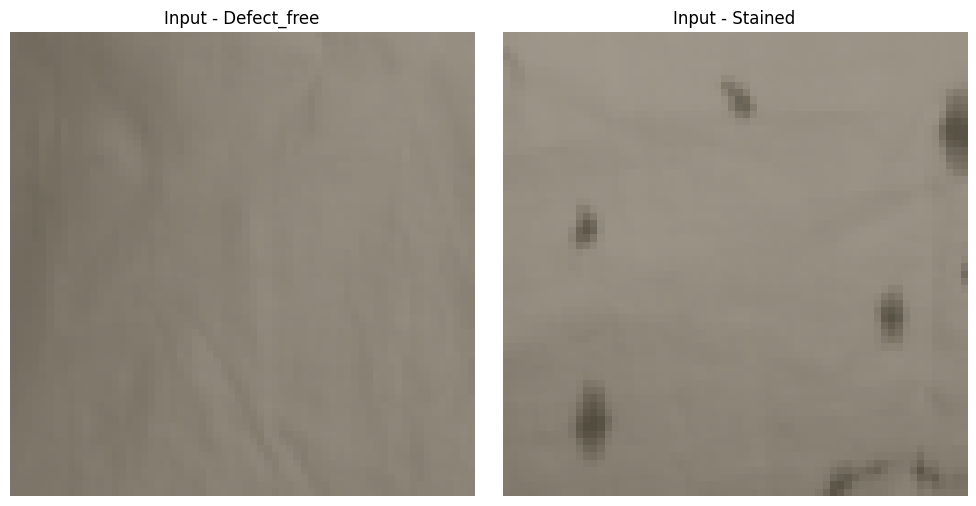

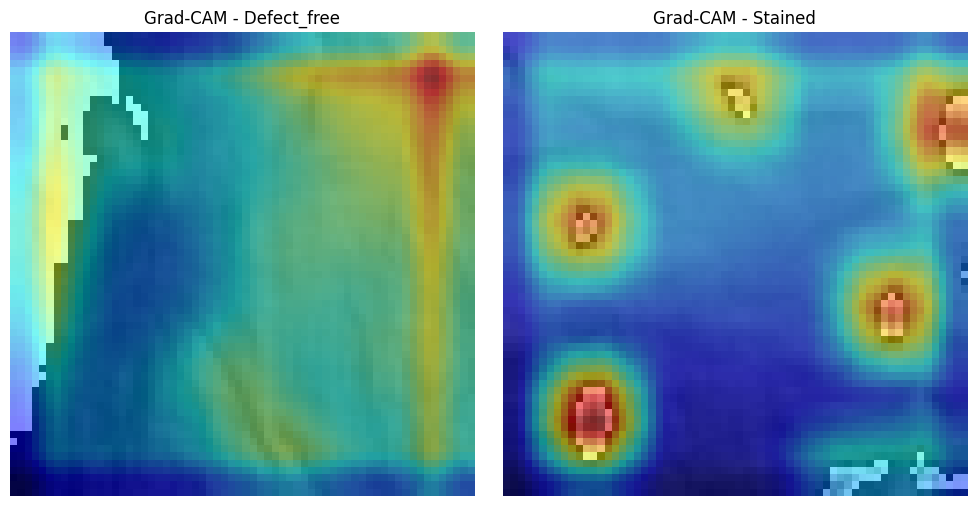

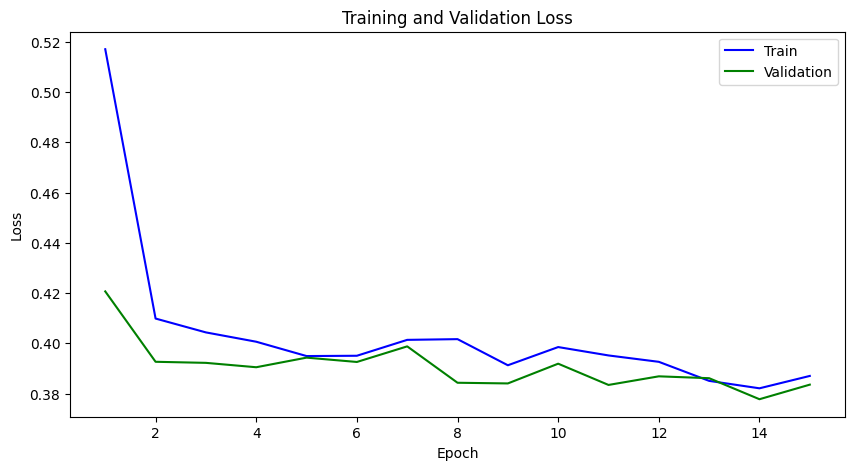

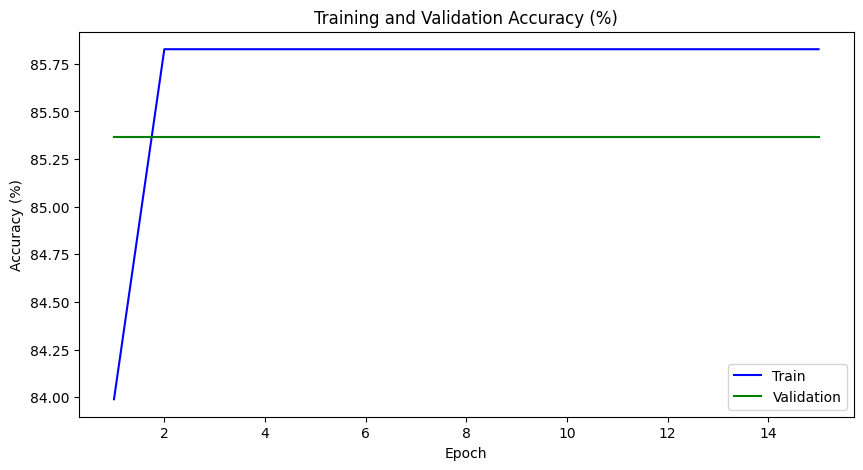

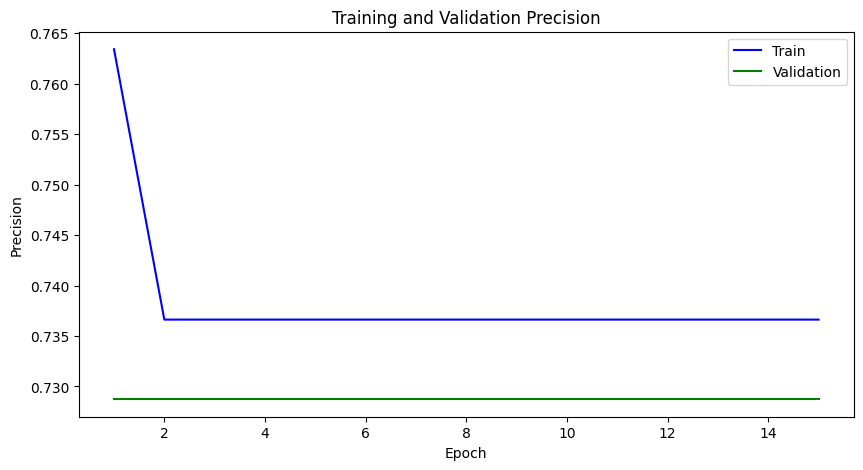

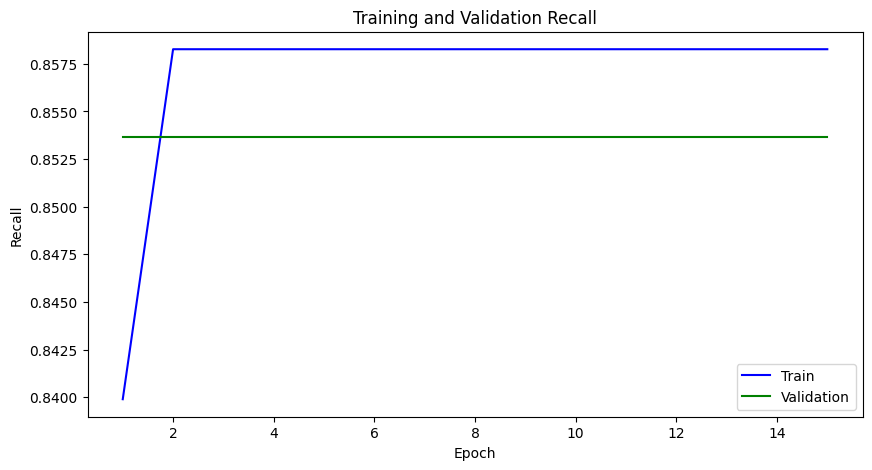

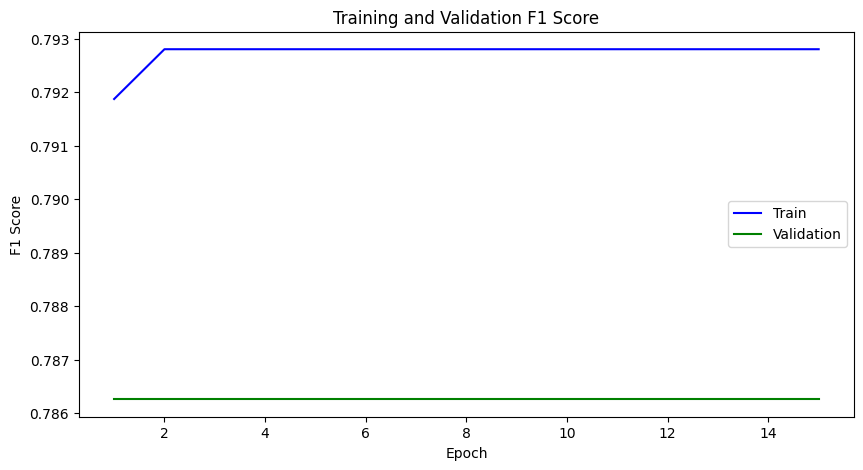

In [30]:
train_model_with_metrics_tqdm(model_intial_model,train_loader, valid_loader, criterion_intial_model, optimizer_intial_model, num_epochs=15)

## Improved Model

Epoch [1/15]:
  Training Loss: 2.3568, Accuracy: 60.37%, Precision: 0.78, Recall: 0.60, F1: 0.66
  Validation Loss: 0.8109, Accuracy: 14.63%, Precision: 0.02, Recall: 0.15, F1: 0.04
--------------------------------------------------------------------------------


Epoch [2/15]:
  Training Loss: 1.0792, Accuracy: 50.39%, Precision: 0.83, Recall: 0.50, F1: 0.57
  Validation Loss: 0.6861, Accuracy: 24.39%, Precision: 0.73, Recall: 0.24, F1: 0.24
--------------------------------------------------------------------------------


Epoch [3/15]:
  Training Loss: 0.8555, Accuracy: 53.02%, Precision: 0.79, Recall: 0.53, F1: 0.60
  Validation Loss: 0.8332, Accuracy: 14.63%, Precision: 0.02, Recall: 0.15, F1: 0.04
--------------------------------------------------------------------------------


Epoch [4/15]:
  Training Loss: 0.6840, Accuracy: 53.02%, Precision: 0.86, Recall: 0.53, F1: 0.59
  Validation Loss: 0.9697, Accuracy: 14.63%, Precision: 0.02, Recall: 0.15, F1: 0.04
--------------------------------------------------------------------------------


Epoch [5/15]:
  Training Loss: 0.6084, Accuracy: 63.78%, Precision: 0.84, Recall: 0.64, F1: 0.69
  Validation Loss: 0.7989, Accuracy: 21.95%, Precision: 0.88, Recall: 0.22, F1: 0.17
--------------------------------------------------------------------------------


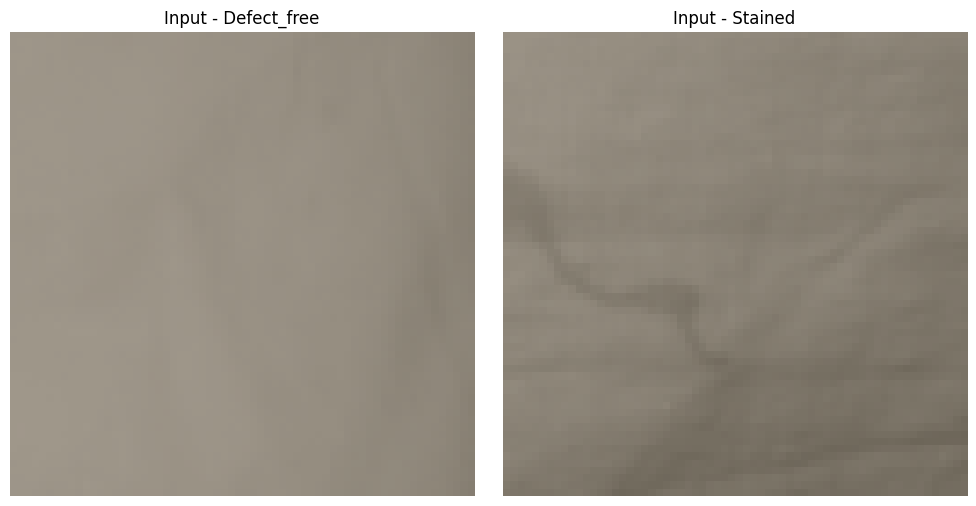

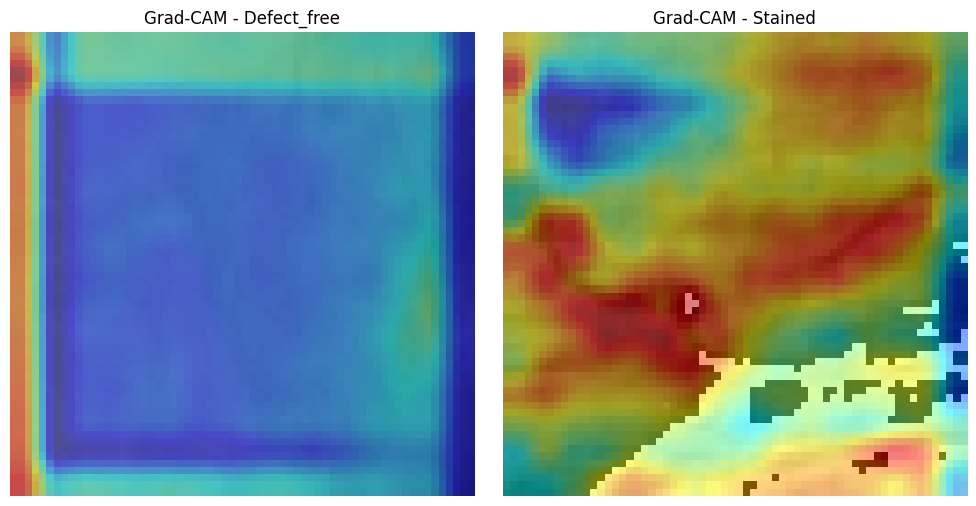

Epoch [6/15]:
  Training Loss: 0.6288, Accuracy: 62.73%, Precision: 0.82, Recall: 0.63, F1: 0.68
  Validation Loss: 0.7377, Accuracy: 24.39%, Precision: 0.88, Recall: 0.24, F1: 0.22
--------------------------------------------------------------------------------


Epoch [7/15]:
  Training Loss: 0.5979, Accuracy: 58.01%, Precision: 0.84, Recall: 0.58, F1: 0.64
  Validation Loss: 0.7855, Accuracy: 30.49%, Precision: 0.88, Recall: 0.30, F1: 0.31
--------------------------------------------------------------------------------


Epoch [8/15]:
  Training Loss: 0.6486, Accuracy: 61.68%, Precision: 0.85, Recall: 0.62, F1: 0.67
  Validation Loss: 0.9055, Accuracy: 31.71%, Precision: 0.88, Recall: 0.32, F1: 0.33
--------------------------------------------------------------------------------


Epoch [9/15]:
  Training Loss: 0.7004, Accuracy: 72.70%, Precision: 0.83, Recall: 0.73, F1: 0.76
  Validation Loss: 1.5013, Accuracy: 19.51%, Precision: 0.88, Recall: 0.20, F1: 0.13
--------------------------------------------------------------------------------


Epoch [10/15]:
  Training Loss: 0.8343, Accuracy: 58.27%, Precision: 0.85, Recall: 0.58, F1: 0.64
  Validation Loss: 0.7083, Accuracy: 47.56%, Precision: 0.89, Recall: 0.48, F1: 0.53
--------------------------------------------------------------------------------


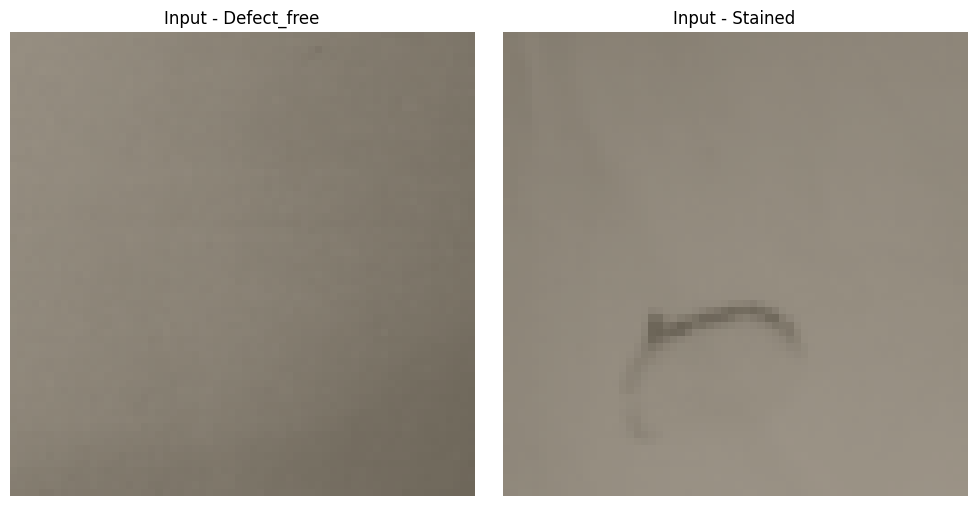

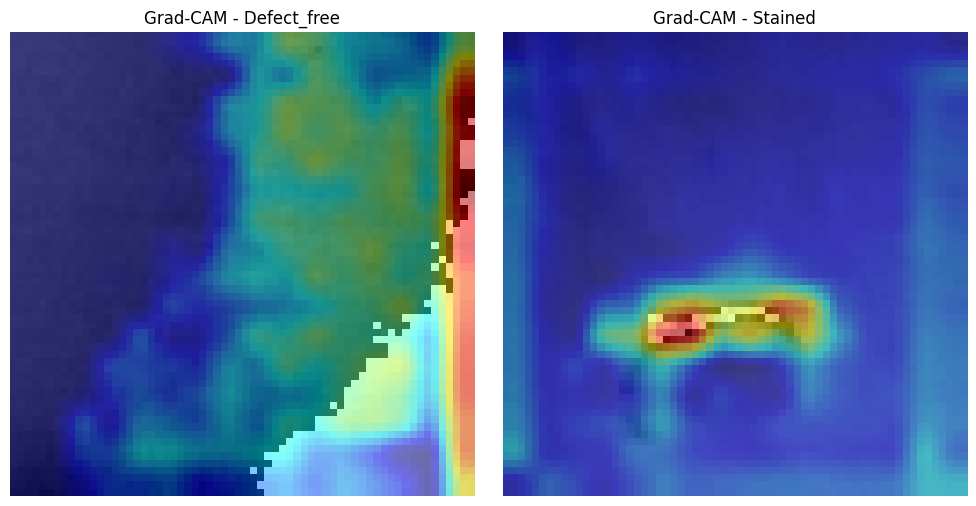

Epoch [11/15]:
  Training Loss: 0.5798, Accuracy: 62.73%, Precision: 0.85, Recall: 0.63, F1: 0.68
  Validation Loss: 0.7365, Accuracy: 43.90%, Precision: 0.88, Recall: 0.44, F1: 0.49
--------------------------------------------------------------------------------


Epoch [12/15]:
  Training Loss: 0.6389, Accuracy: 60.37%, Precision: 0.83, Recall: 0.60, F1: 0.66
  Validation Loss: 0.7451, Accuracy: 36.59%, Precision: 0.88, Recall: 0.37, F1: 0.40
--------------------------------------------------------------------------------


Epoch [13/15]:
  Training Loss: 0.5822, Accuracy: 74.80%, Precision: 0.84, Recall: 0.75, F1: 0.78
  Validation Loss: 0.8301, Accuracy: 39.02%, Precision: 0.88, Recall: 0.39, F1: 0.43
--------------------------------------------------------------------------------


Epoch [14/15]:
  Training Loss: 0.5972, Accuracy: 60.10%, Precision: 0.87, Recall: 0.60, F1: 0.66
  Validation Loss: 0.8841, Accuracy: 36.59%, Precision: 0.88, Recall: 0.37, F1: 0.40
--------------------------------------------------------------------------------


Epoch [15/15]:
  Training Loss: 0.6335, Accuracy: 66.67%, Precision: 0.83, Recall: 0.67, F1: 0.72
  Validation Loss: 0.9085, Accuracy: 35.37%, Precision: 0.88, Recall: 0.35, F1: 0.38
--------------------------------------------------------------------------------


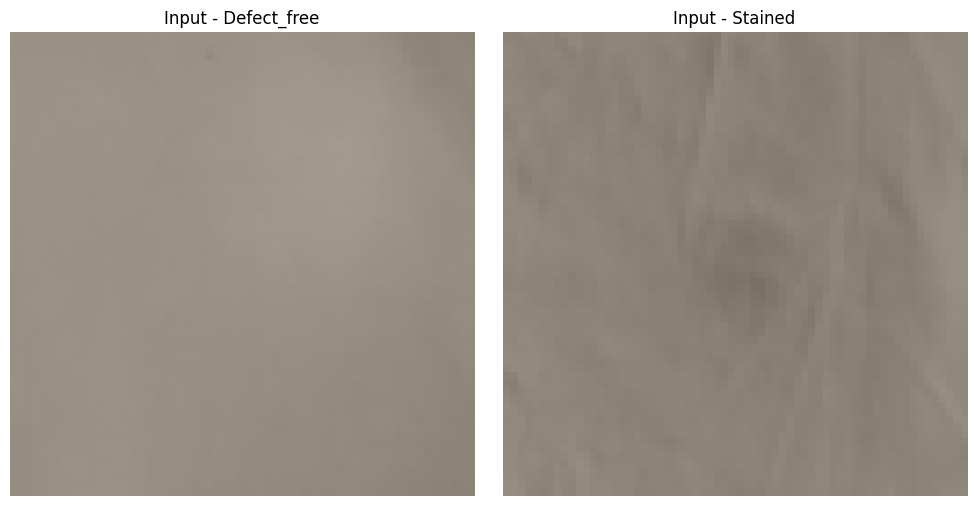

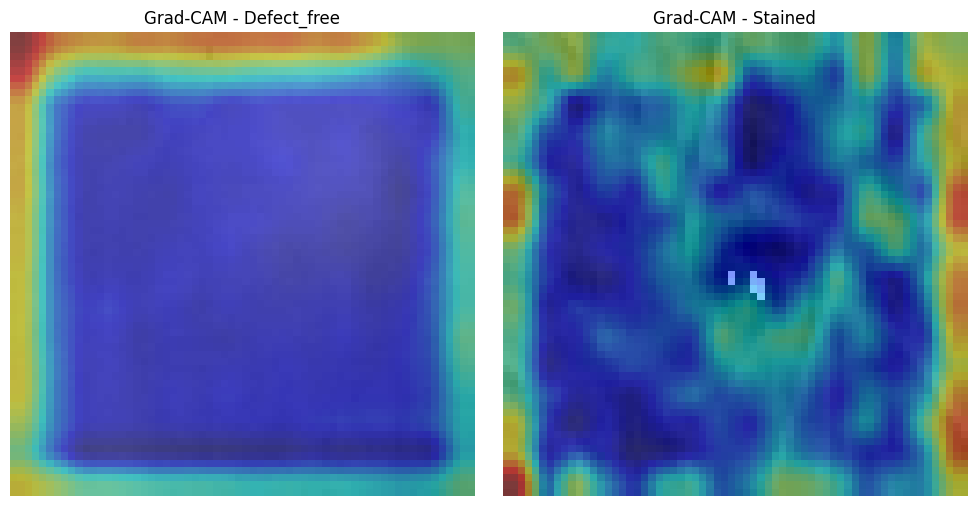

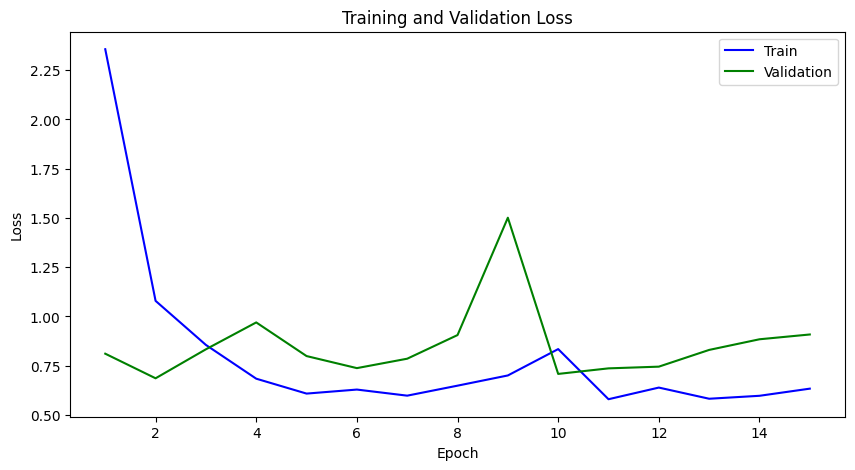

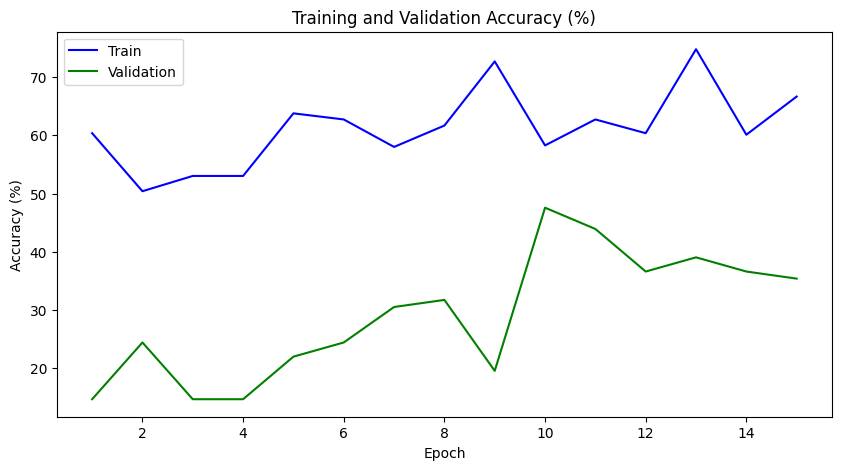

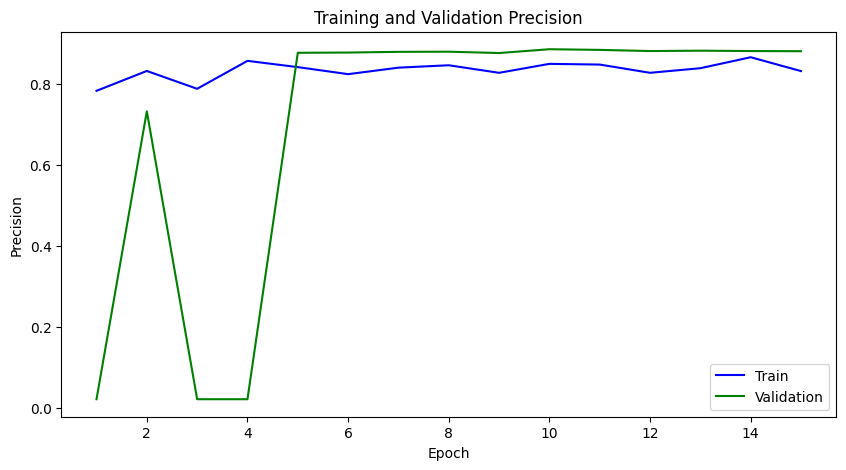

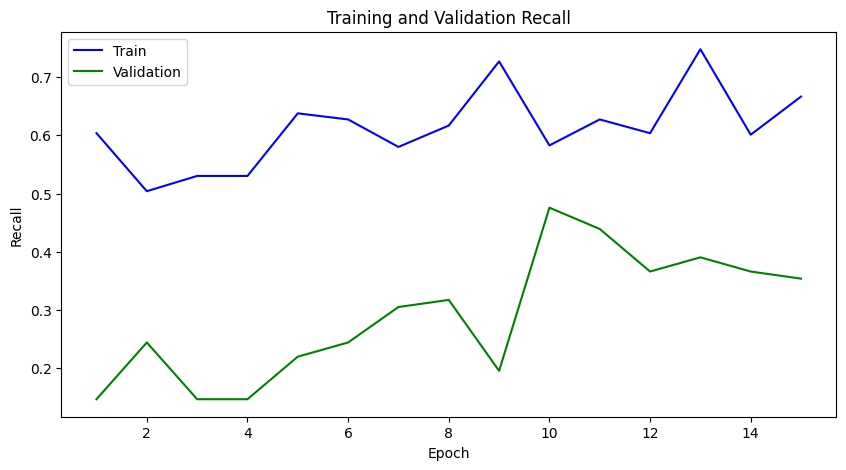

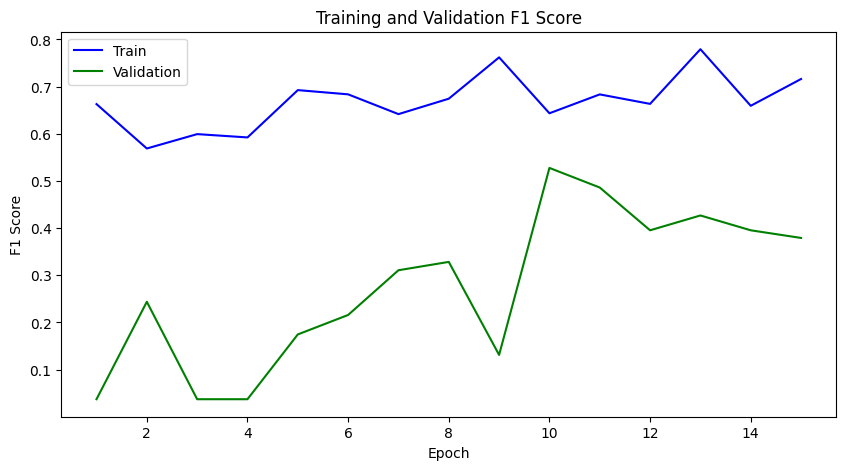

In [31]:
train_model_with_metrics_tqdm(model_improved,train_loader, valid_loader, criterion_improved_model, optimizer_improved_model, num_epochs=15)

## EfficientNet

Epoch [1/15]:
  Training Loss: 0.6223, Accuracy: 66.67%, Precision: 0.80, Recall: 0.67, F1: 0.71
  Validation Loss: 0.5543, Accuracy: 74.39%, Precision: 0.71, Recall: 0.74, F1: 0.73
--------------------------------------------------------------------------------


Epoch [2/15]:
  Training Loss: 0.5238, Accuracy: 78.74%, Precision: 0.82, Recall: 0.79, F1: 0.80
  Validation Loss: 2.7965, Accuracy: 85.37%, Precision: 0.81, Recall: 0.85, F1: 0.81
--------------------------------------------------------------------------------


Epoch [3/15]:
  Training Loss: 0.4368, Accuracy: 83.99%, Precision: 0.84, Recall: 0.84, F1: 0.84
  Validation Loss: 2.4749, Accuracy: 81.71%, Precision: 0.72, Recall: 0.82, F1: 0.77
--------------------------------------------------------------------------------


Epoch [4/15]:
  Training Loss: 0.3605, Accuracy: 90.29%, Precision: 0.90, Recall: 0.90, F1: 0.90
  Validation Loss: 0.5154, Accuracy: 80.49%, Precision: 0.77, Recall: 0.80, F1: 0.79
--------------------------------------------------------------------------------


Epoch [5/15]:
  Training Loss: 0.3139, Accuracy: 90.55%, Precision: 0.90, Recall: 0.91, F1: 0.90
  Validation Loss: 0.5105, Accuracy: 80.49%, Precision: 0.79, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


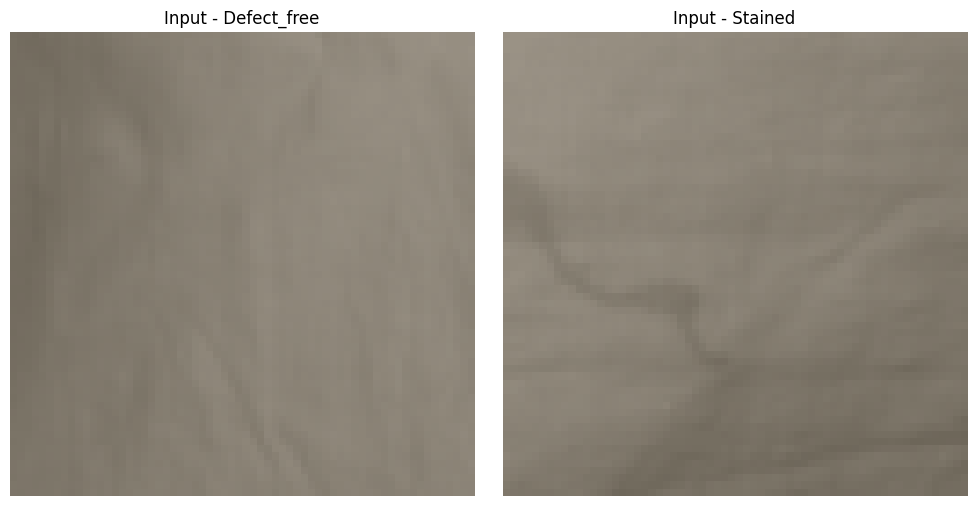

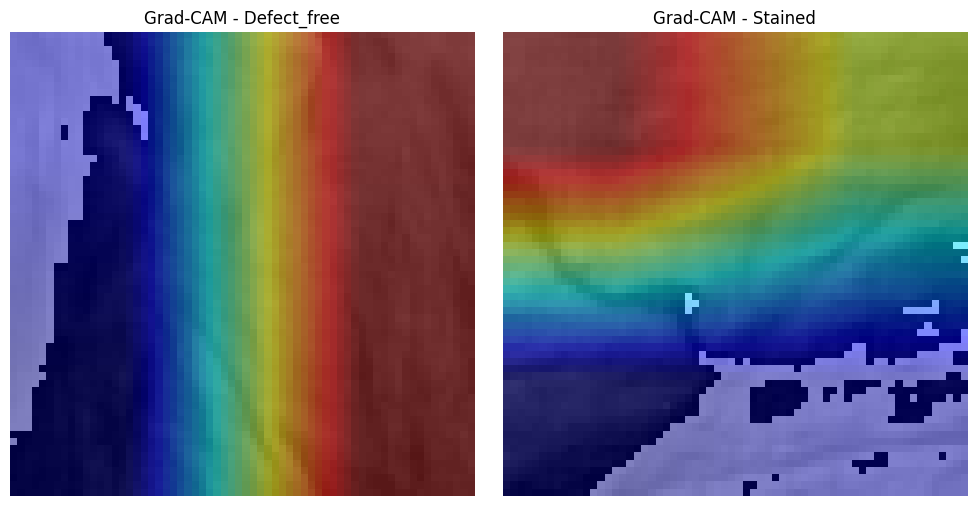

Epoch [6/15]:
  Training Loss: 0.2918, Accuracy: 91.86%, Precision: 0.91, Recall: 0.92, F1: 0.91
  Validation Loss: 0.4860, Accuracy: 81.71%, Precision: 0.80, Recall: 0.82, F1: 0.81
--------------------------------------------------------------------------------


Epoch [7/15]:
  Training Loss: 0.2479, Accuracy: 94.49%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.4401, Accuracy: 80.49%, Precision: 0.79, Recall: 0.80, F1: 0.80
--------------------------------------------------------------------------------


Epoch [8/15]:
  Training Loss: 0.2366, Accuracy: 94.23%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.4178, Accuracy: 82.93%, Precision: 0.80, Recall: 0.83, F1: 0.81
--------------------------------------------------------------------------------


Epoch [9/15]:
  Training Loss: 0.2395, Accuracy: 93.96%, Precision: 0.94, Recall: 0.94, F1: 0.94
  Validation Loss: 0.4016, Accuracy: 89.02%, Precision: 0.88, Recall: 0.89, F1: 0.87
--------------------------------------------------------------------------------


Epoch [10/15]:
  Training Loss: 0.1713, Accuracy: 97.38%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.3645, Accuracy: 89.02%, Precision: 0.88, Recall: 0.89, F1: 0.88
--------------------------------------------------------------------------------


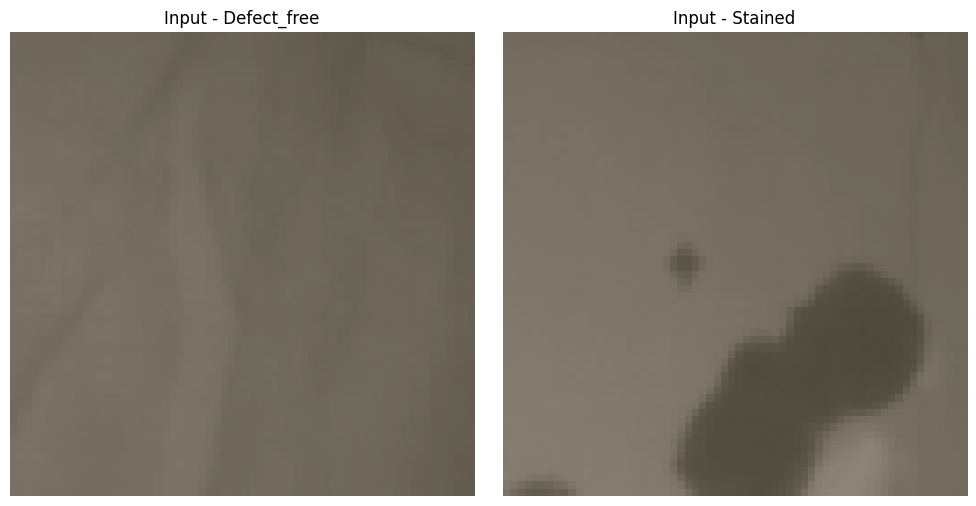

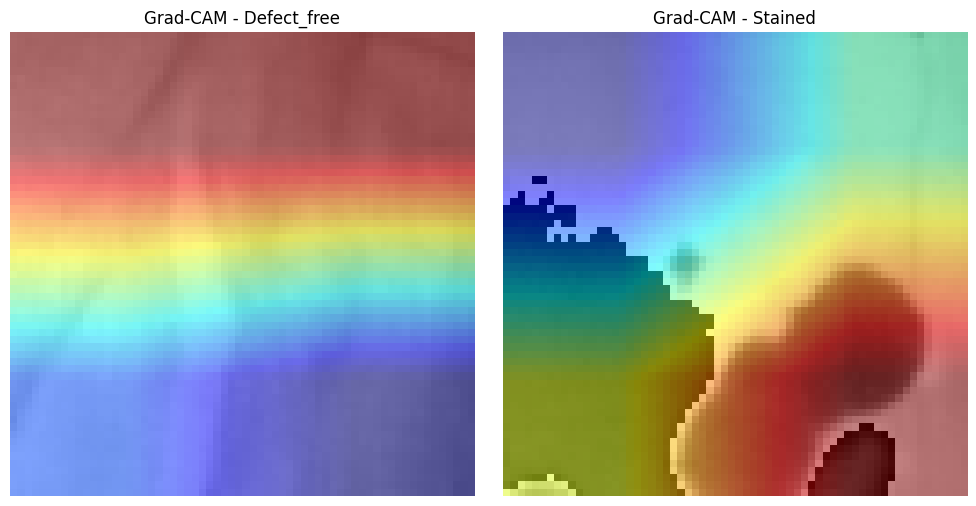

Epoch [11/15]:
  Training Loss: 0.1663, Accuracy: 97.38%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.3547, Accuracy: 90.24%, Precision: 0.90, Recall: 0.90, F1: 0.89
--------------------------------------------------------------------------------


Epoch [12/15]:
  Training Loss: 0.1663, Accuracy: 95.80%, Precision: 0.96, Recall: 0.96, F1: 0.96
  Validation Loss: 0.3625, Accuracy: 85.37%, Precision: 0.84, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [13/15]:
  Training Loss: 0.1445, Accuracy: 96.59%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.3616, Accuracy: 84.15%, Precision: 0.81, Recall: 0.84, F1: 0.82
--------------------------------------------------------------------------------


Epoch [14/15]:
  Training Loss: 0.1162, Accuracy: 98.43%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.3522, Accuracy: 85.37%, Precision: 0.83, Recall: 0.85, F1: 0.84
--------------------------------------------------------------------------------


Epoch [15/15]:
  Training Loss: 0.1209, Accuracy: 98.43%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.3788, Accuracy: 89.02%, Precision: 0.88, Recall: 0.89, F1: 0.88
--------------------------------------------------------------------------------


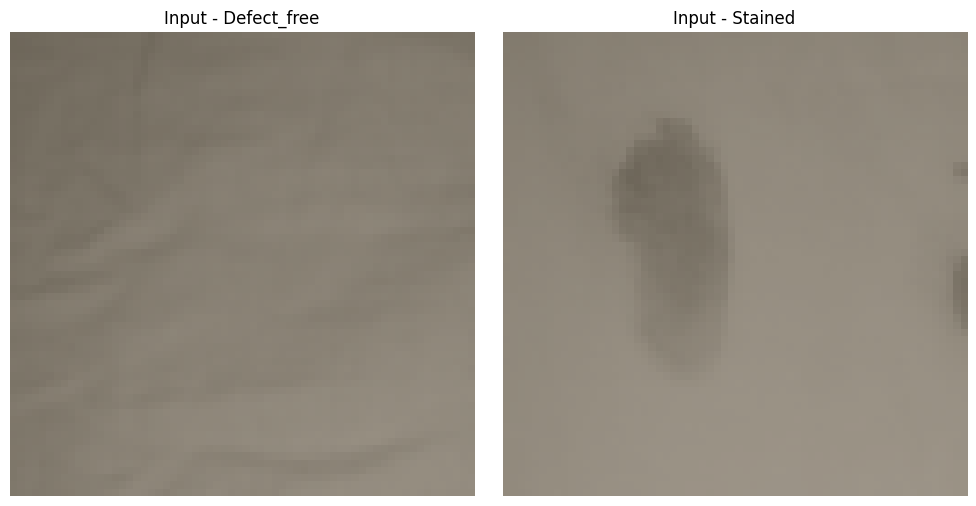

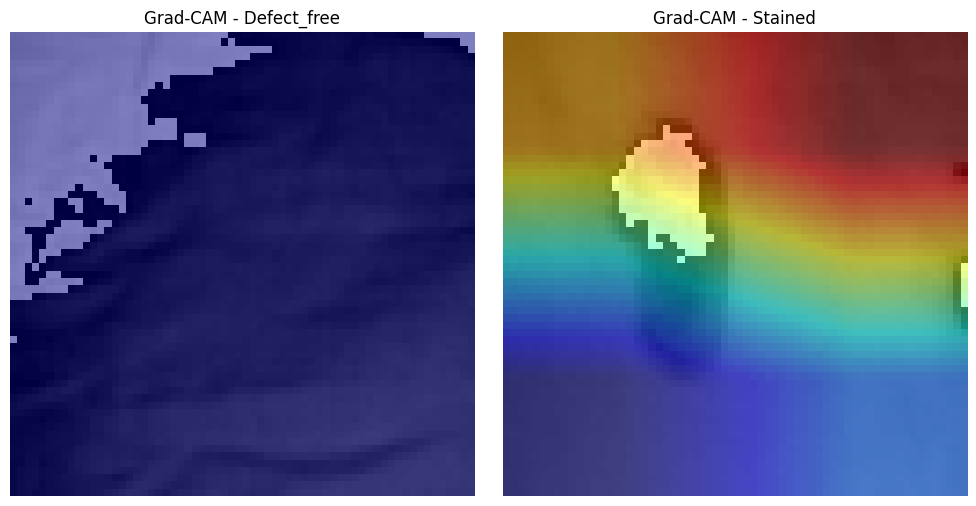

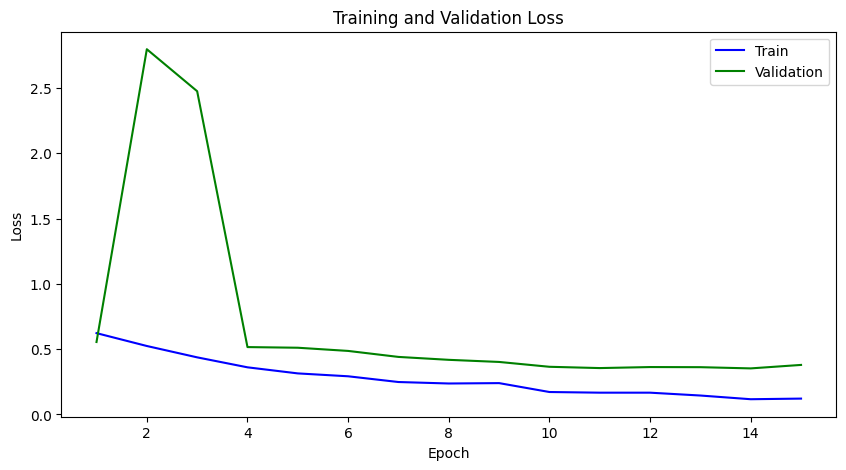

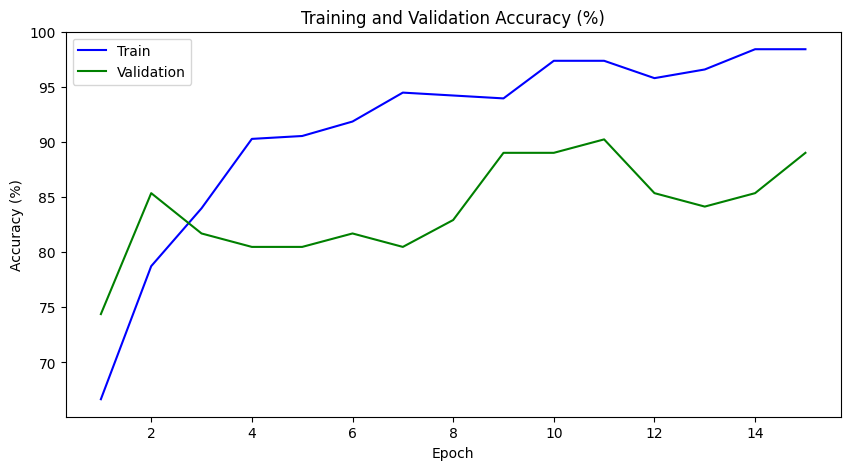

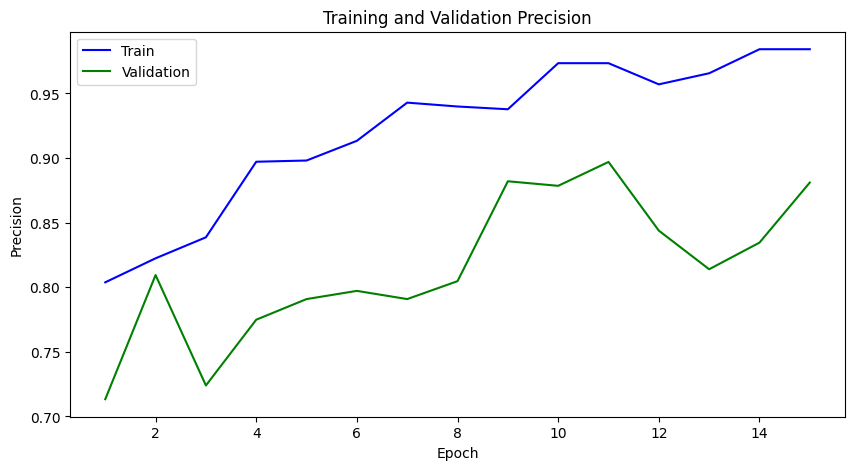

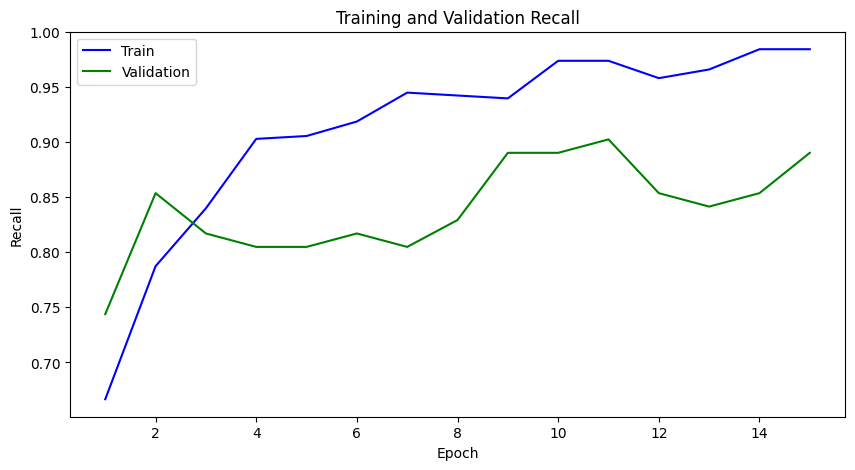

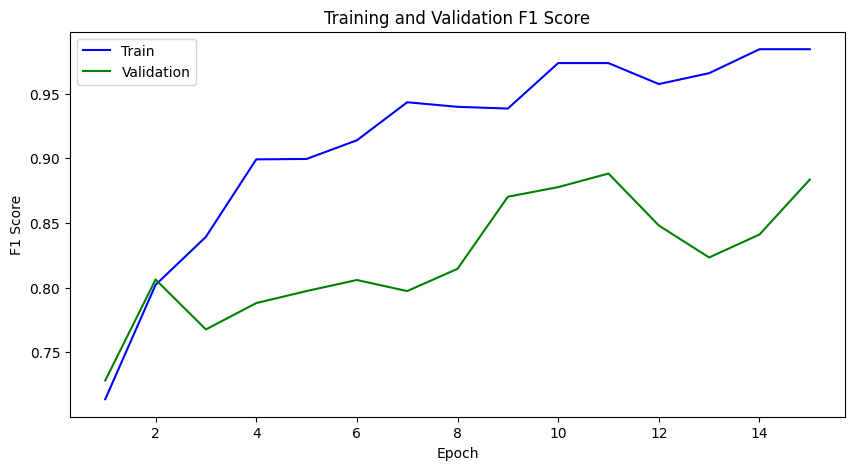

In [32]:
train_model_with_metrics_tqdm(model_efficient,train_loader, valid_loader, criterion_efficient, optimizer_efficient, num_epochs=15)

## Ef Tuned

Epoch [1/15]:
  Training Loss: 0.6988, Accuracy: 62.20%, Precision: 0.77, Recall: 0.62, F1: 0.68
  Validation Loss: 0.7244, Accuracy: 31.71%, Precision: 0.82, Recall: 0.32, F1: 0.34
--------------------------------------------------------------------------------


Epoch [2/15]:
  Training Loss: 0.6055, Accuracy: 67.72%, Precision: 0.84, Recall: 0.68, F1: 0.72
  Validation Loss: 13.6725, Accuracy: 73.17%, Precision: 0.75, Recall: 0.73, F1: 0.74
--------------------------------------------------------------------------------


Epoch [3/15]:
  Training Loss: 0.5567, Accuracy: 69.29%, Precision: 0.85, Recall: 0.69, F1: 0.74
  Validation Loss: 0.7140, Accuracy: 58.54%, Precision: 0.81, Recall: 0.59, F1: 0.65
--------------------------------------------------------------------------------


Epoch [4/15]:
  Training Loss: 0.5181, Accuracy: 70.60%, Precision: 0.86, Recall: 0.71, F1: 0.75
  Validation Loss: 0.6934, Accuracy: 43.90%, Precision: 0.79, Recall: 0.44, F1: 0.50
--------------------------------------------------------------------------------


Epoch [5/15]:
  Training Loss: 0.4744, Accuracy: 75.07%, Precision: 0.87, Recall: 0.75, F1: 0.79
  Validation Loss: 0.6125, Accuracy: 48.78%, Precision: 0.86, Recall: 0.49, F1: 0.55
--------------------------------------------------------------------------------


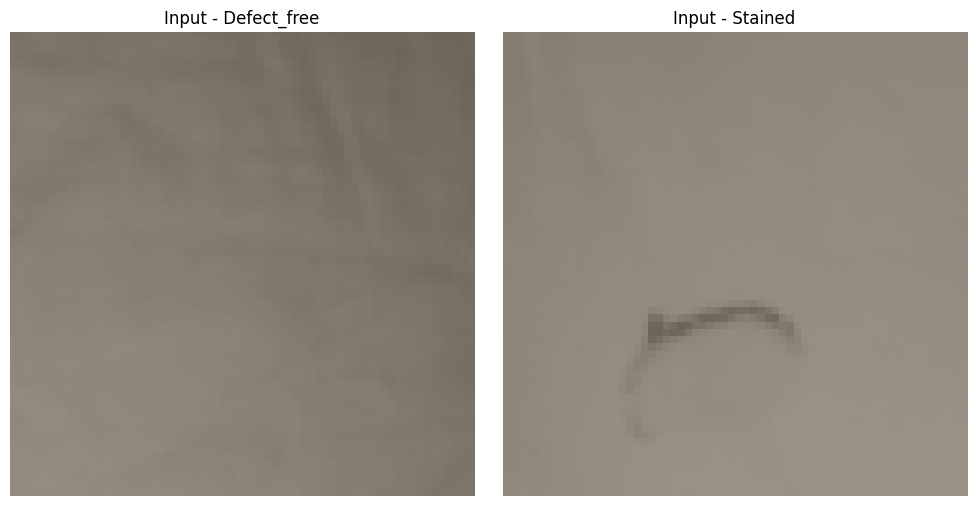

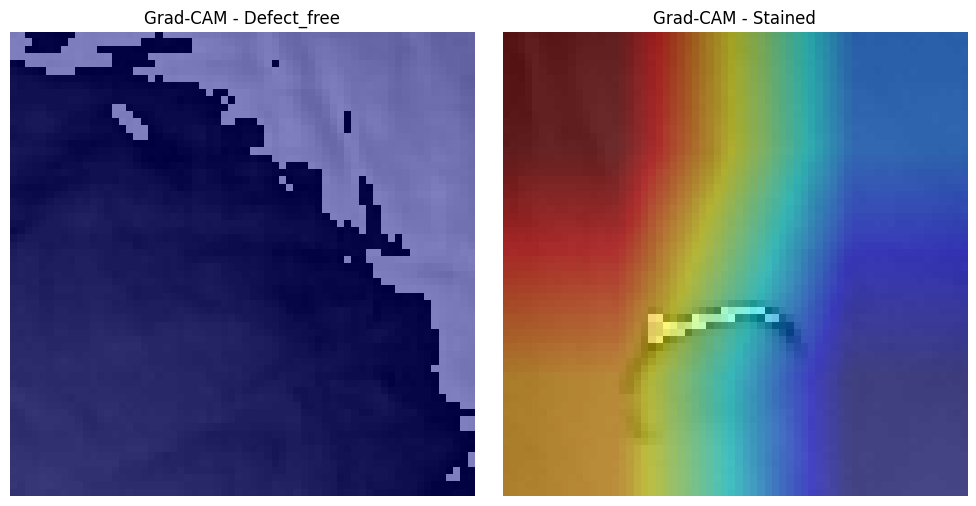

Epoch [6/15]:
  Training Loss: 0.4432, Accuracy: 75.59%, Precision: 0.90, Recall: 0.76, F1: 0.79
  Validation Loss: 0.6268, Accuracy: 57.32%, Precision: 0.82, Recall: 0.57, F1: 0.63
--------------------------------------------------------------------------------


Epoch [7/15]:
  Training Loss: 0.3951, Accuracy: 79.27%, Precision: 0.91, Recall: 0.79, F1: 0.82
  Validation Loss: 0.6971, Accuracy: 67.07%, Precision: 0.82, Recall: 0.67, F1: 0.72
--------------------------------------------------------------------------------


Epoch [8/15]:
  Training Loss: 0.4041, Accuracy: 82.94%, Precision: 0.90, Recall: 0.83, F1: 0.85
  Validation Loss: 0.5941, Accuracy: 68.29%, Precision: 0.83, Recall: 0.68, F1: 0.73
--------------------------------------------------------------------------------


Epoch [9/15]:
  Training Loss: 0.3799, Accuracy: 82.15%, Precision: 0.90, Recall: 0.82, F1: 0.84
  Validation Loss: 0.6240, Accuracy: 76.83%, Precision: 0.85, Recall: 0.77, F1: 0.79
--------------------------------------------------------------------------------


Epoch [10/15]:
  Training Loss: 0.3168, Accuracy: 85.56%, Precision: 0.93, Recall: 0.86, F1: 0.87
  Validation Loss: 0.6162, Accuracy: 76.83%, Precision: 0.85, Recall: 0.77, F1: 0.79
--------------------------------------------------------------------------------


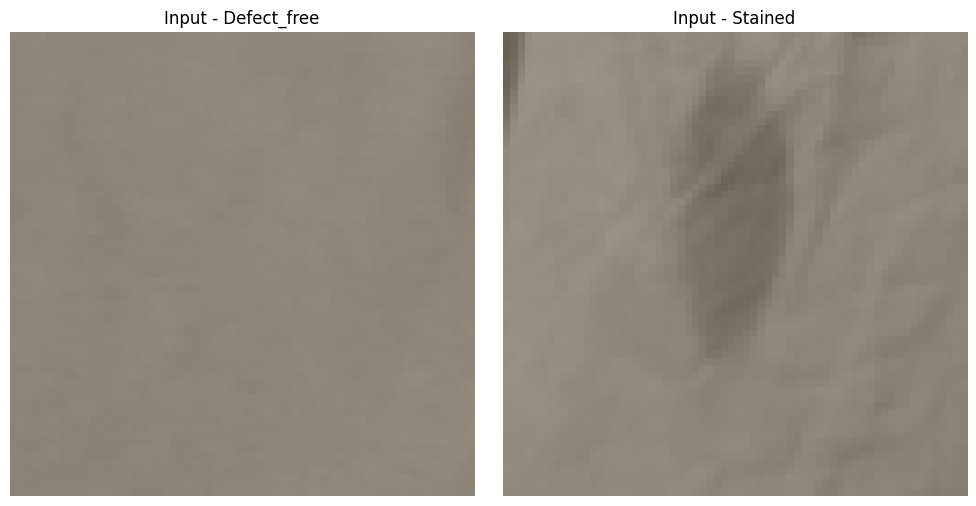

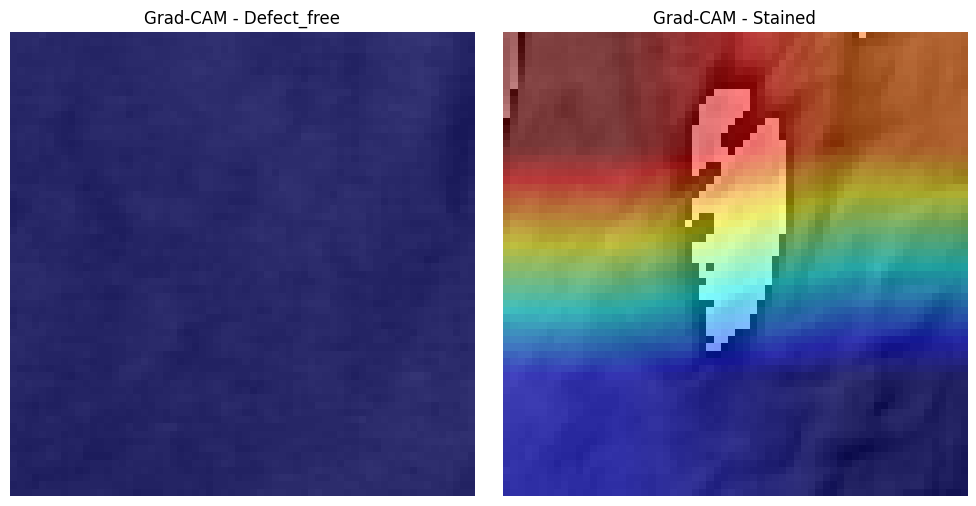

Epoch [11/15]:
  Training Loss: 0.3025, Accuracy: 86.61%, Precision: 0.93, Recall: 0.87, F1: 0.88
  Validation Loss: 0.6588, Accuracy: 79.27%, Precision: 0.85, Recall: 0.79, F1: 0.81
--------------------------------------------------------------------------------


Epoch [12/15]:
  Training Loss: 0.2692, Accuracy: 87.40%, Precision: 0.93, Recall: 0.87, F1: 0.89
  Validation Loss: 0.6532, Accuracy: 80.49%, Precision: 0.86, Recall: 0.80, F1: 0.82
--------------------------------------------------------------------------------


Epoch [13/15]:
  Training Loss: 0.2746, Accuracy: 89.24%, Precision: 0.94, Recall: 0.89, F1: 0.90
  Validation Loss: 0.6569, Accuracy: 76.83%, Precision: 0.83, Recall: 0.77, F1: 0.79
--------------------------------------------------------------------------------


Epoch [14/15]:
  Training Loss: 0.2788, Accuracy: 86.88%, Precision: 0.92, Recall: 0.87, F1: 0.88
  Validation Loss: 0.6458, Accuracy: 80.49%, Precision: 0.86, Recall: 0.80, F1: 0.82
--------------------------------------------------------------------------------


Epoch [15/15]:
  Training Loss: 0.2479, Accuracy: 87.93%, Precision: 0.93, Recall: 0.88, F1: 0.89
  Validation Loss: 0.6540, Accuracy: 78.05%, Precision: 0.85, Recall: 0.78, F1: 0.80
--------------------------------------------------------------------------------


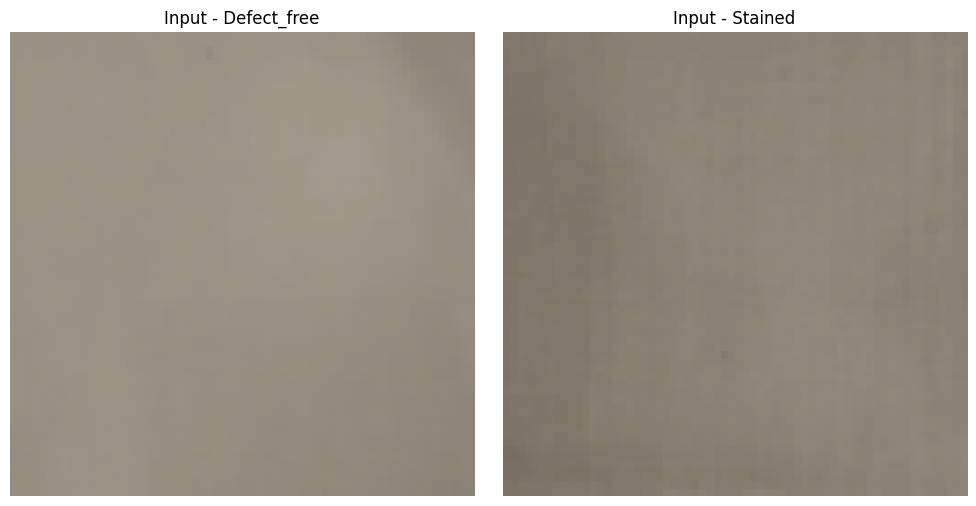

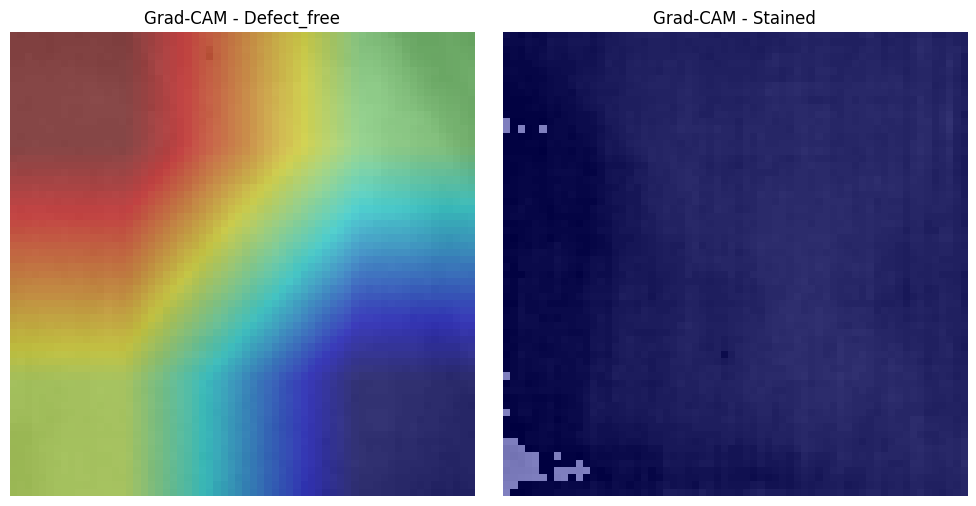

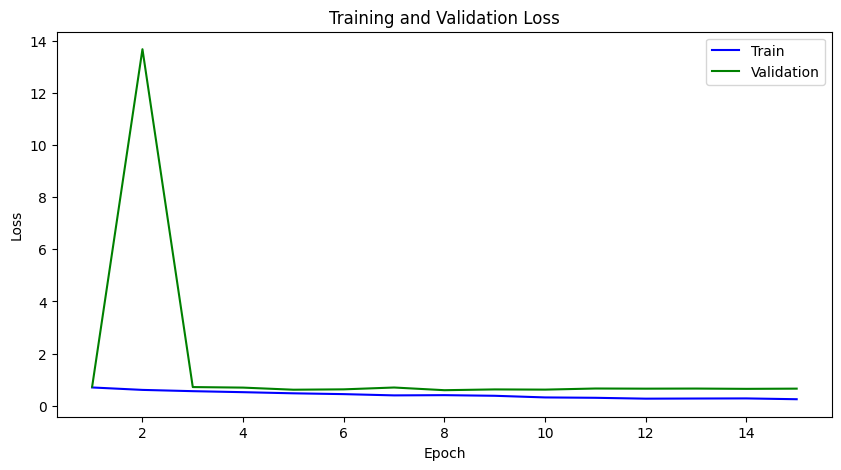

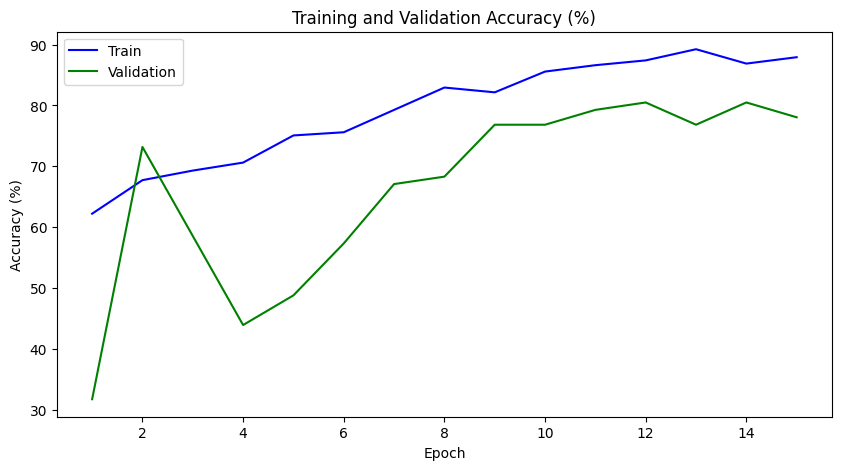

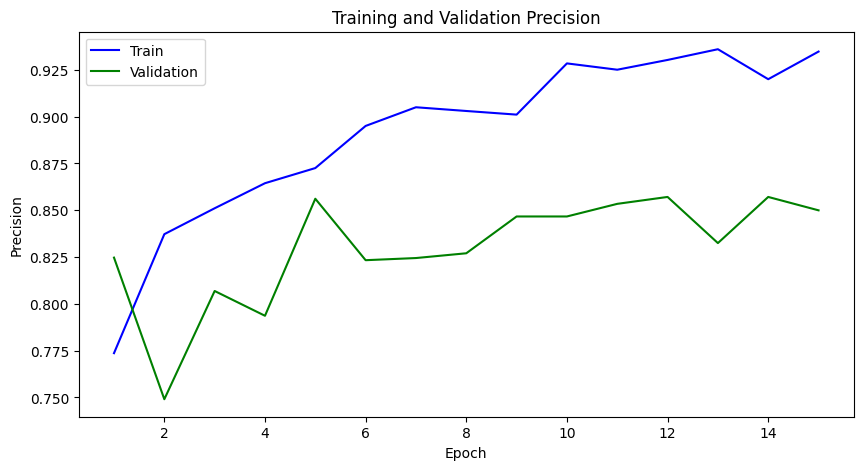

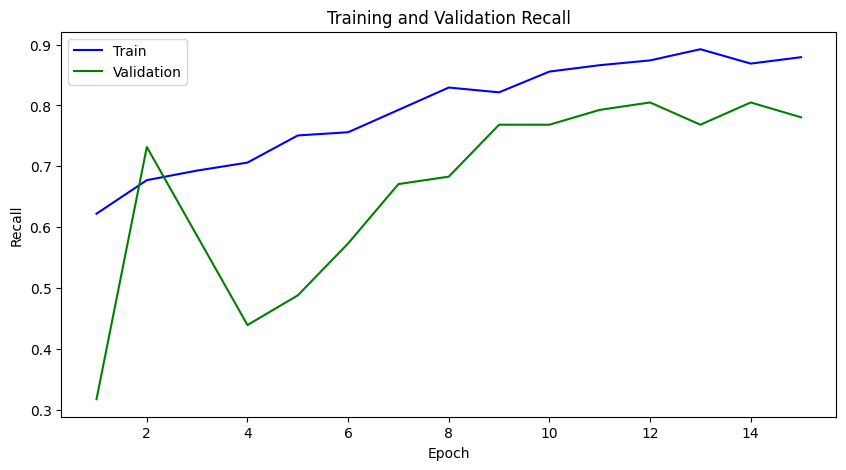

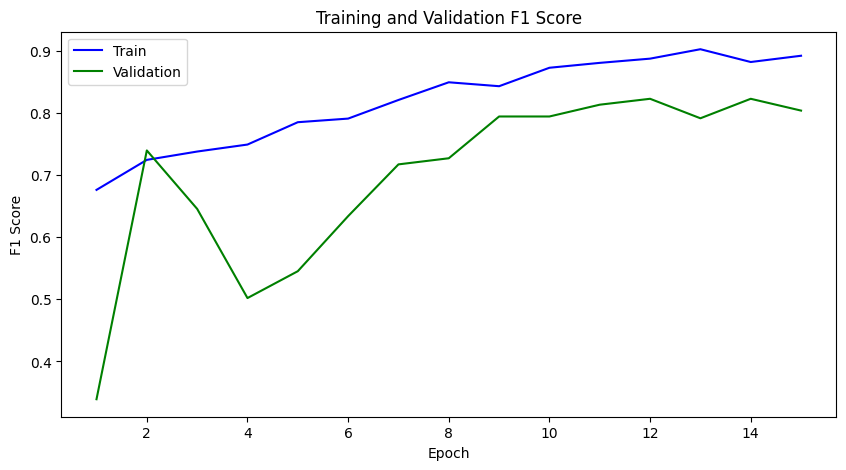

In [33]:
train_model_with_metrics_tqdm(model_efficient_tuned,train_loader, valid_loader, criterion_efficient_tuned,optimizer_efficient_tuned,scheduler_efficient_tuned,num_epochs=15)

## ResNet

Epoch [1/15]:
  Training Loss: 0.7242, Accuracy: 59.06%, Precision: 0.77, Recall: 0.59, F1: 0.65
  Validation Loss: 0.6039, Accuracy: 69.51%, Precision: 0.72, Recall: 0.70, F1: 0.71
--------------------------------------------------------------------------------


Epoch [2/15]:
  Training Loss: 0.3573, Accuracy: 87.40%, Precision: 0.88, Recall: 0.87, F1: 0.88
  Validation Loss: 0.4418, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [3/15]:
  Training Loss: 0.2534, Accuracy: 92.13%, Precision: 0.92, Recall: 0.92, F1: 0.92
  Validation Loss: 0.4367, Accuracy: 85.37%, Precision: 0.73, Recall: 0.85, F1: 0.79
--------------------------------------------------------------------------------


Epoch [4/15]:
  Training Loss: 0.1495, Accuracy: 95.28%, Precision: 0.95, Recall: 0.95, F1: 0.95
  Validation Loss: 0.5030, Accuracy: 84.15%, Precision: 0.73, Recall: 0.84, F1: 0.78
--------------------------------------------------------------------------------


Epoch [5/15]:
  Training Loss: 0.1056, Accuracy: 96.85%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.5718, Accuracy: 84.15%, Precision: 0.73, Recall: 0.84, F1: 0.78
--------------------------------------------------------------------------------


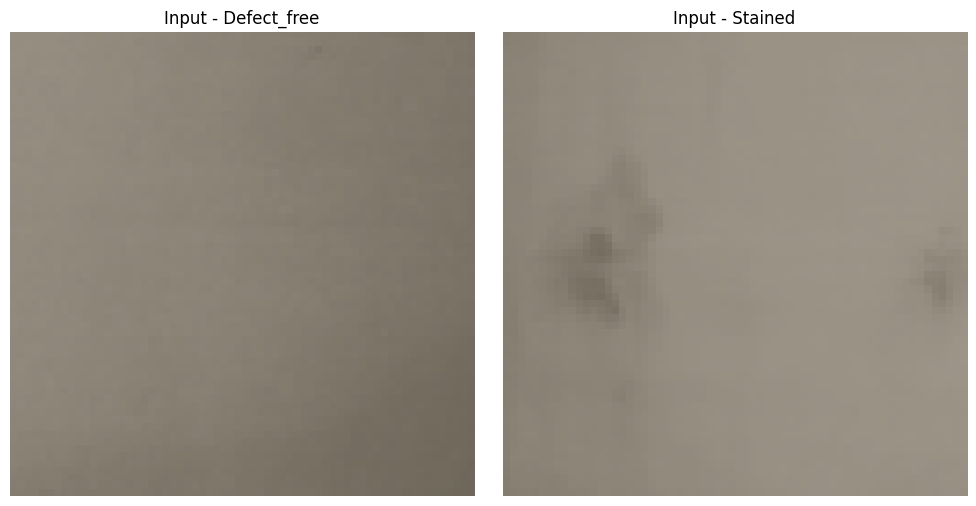

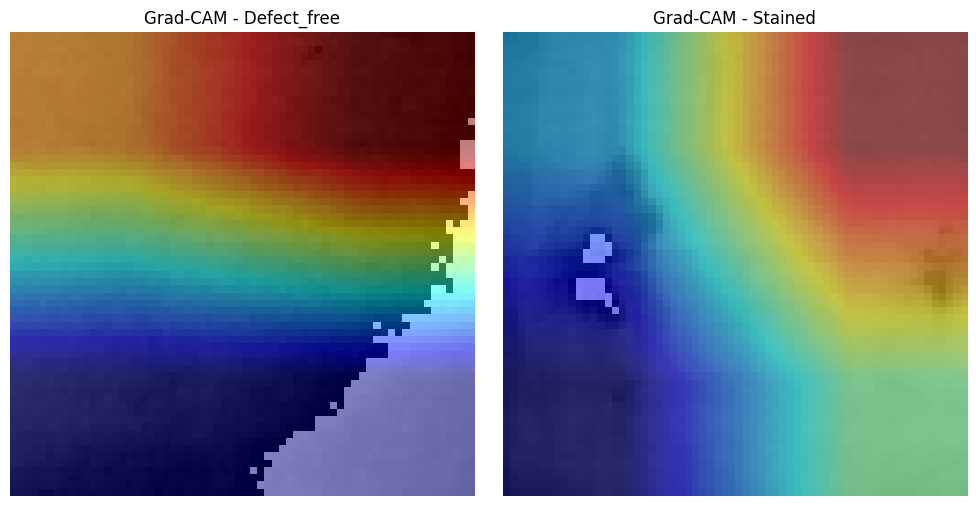

Epoch [6/15]:
  Training Loss: 0.0887, Accuracy: 97.64%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.4869, Accuracy: 81.71%, Precision: 0.76, Recall: 0.82, F1: 0.78
--------------------------------------------------------------------------------


Epoch [7/15]:
  Training Loss: 0.0806, Accuracy: 97.38%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.4619, Accuracy: 85.37%, Precision: 0.83, Recall: 0.85, F1: 0.83
--------------------------------------------------------------------------------


Epoch [8/15]:
  Training Loss: 0.0942, Accuracy: 97.90%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.5792, Accuracy: 79.27%, Precision: 0.79, Recall: 0.79, F1: 0.79
--------------------------------------------------------------------------------


Epoch [9/15]:
  Training Loss: 0.0616, Accuracy: 98.16%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.5200, Accuracy: 86.59%, Precision: 0.84, Recall: 0.87, F1: 0.83
--------------------------------------------------------------------------------


Epoch [10/15]:
  Training Loss: 0.0605, Accuracy: 98.16%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.4745, Accuracy: 85.37%, Precision: 0.83, Recall: 0.85, F1: 0.83
--------------------------------------------------------------------------------


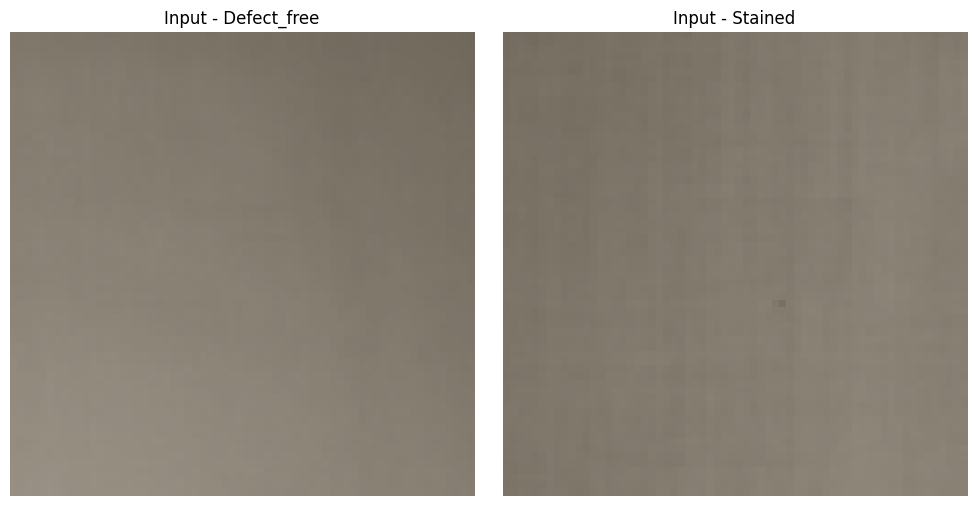

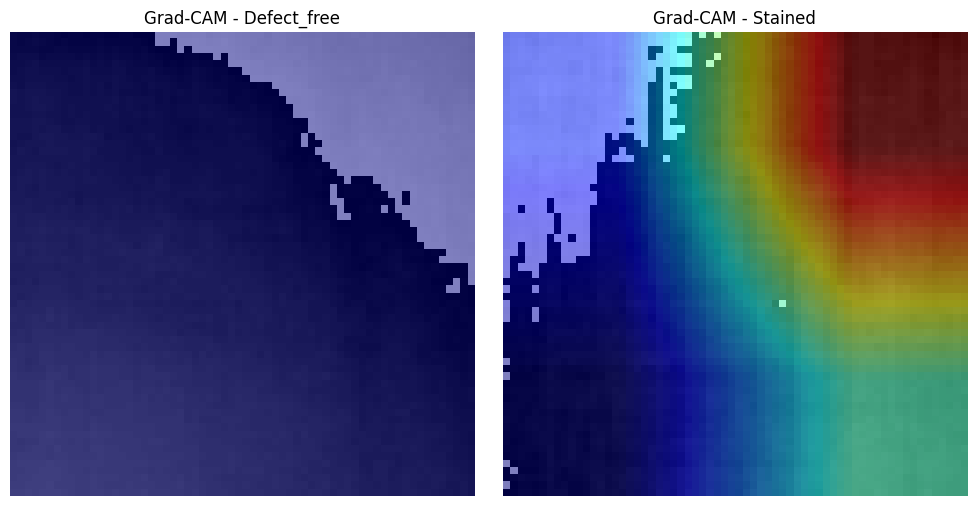

Epoch [11/15]:
  Training Loss: 0.0651, Accuracy: 98.43%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.4578, Accuracy: 85.37%, Precision: 0.84, Recall: 0.85, F1: 0.85
--------------------------------------------------------------------------------


Epoch [12/15]:
  Training Loss: 0.0904, Accuracy: 96.59%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.4877, Accuracy: 86.59%, Precision: 0.85, Recall: 0.87, F1: 0.86
--------------------------------------------------------------------------------


Epoch [13/15]:
  Training Loss: 0.0760, Accuracy: 97.38%, Precision: 0.97, Recall: 0.97, F1: 0.97
  Validation Loss: 0.5002, Accuracy: 84.15%, Precision: 0.83, Recall: 0.84, F1: 0.83
--------------------------------------------------------------------------------


Epoch [14/15]:
  Training Loss: 0.0636, Accuracy: 97.90%, Precision: 0.98, Recall: 0.98, F1: 0.98
  Validation Loss: 0.5313, Accuracy: 87.80%, Precision: 0.86, Recall: 0.88, F1: 0.86
--------------------------------------------------------------------------------


Epoch [15/15]:
  Training Loss: 0.0442, Accuracy: 98.95%, Precision: 0.99, Recall: 0.99, F1: 0.99
  Validation Loss: 0.5882, Accuracy: 86.59%, Precision: 0.85, Recall: 0.87, F1: 0.85
--------------------------------------------------------------------------------


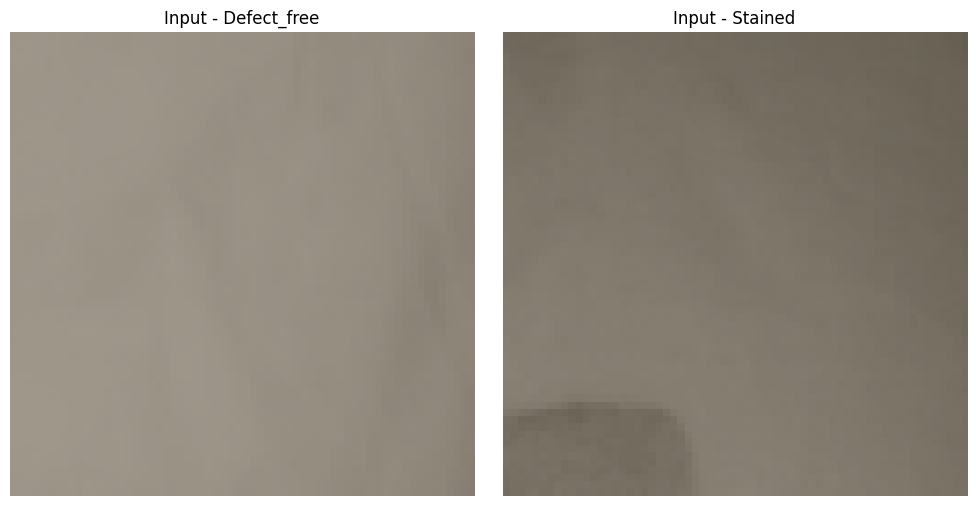

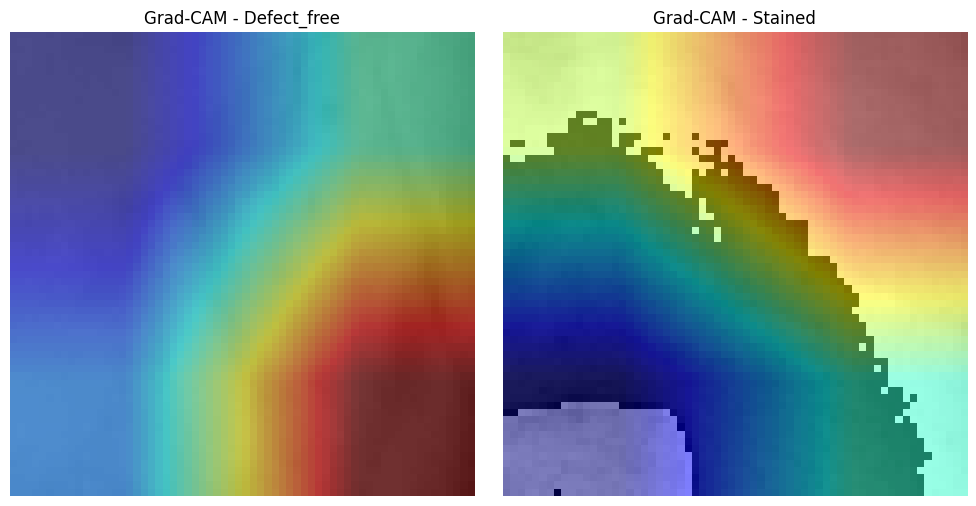

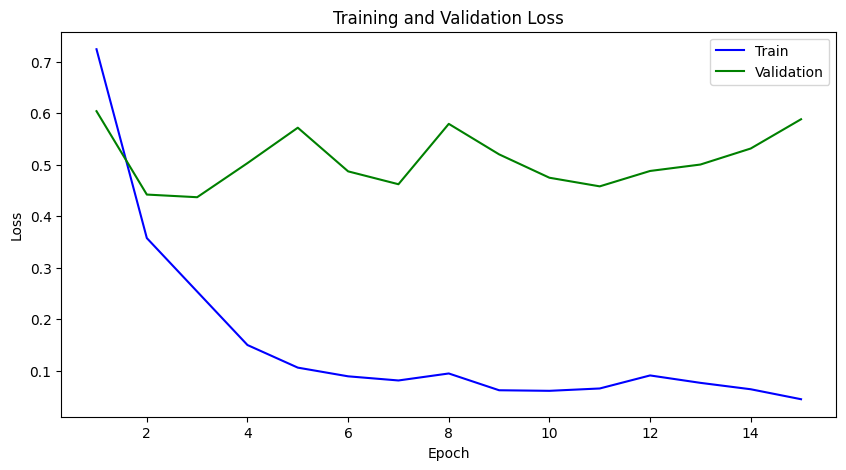

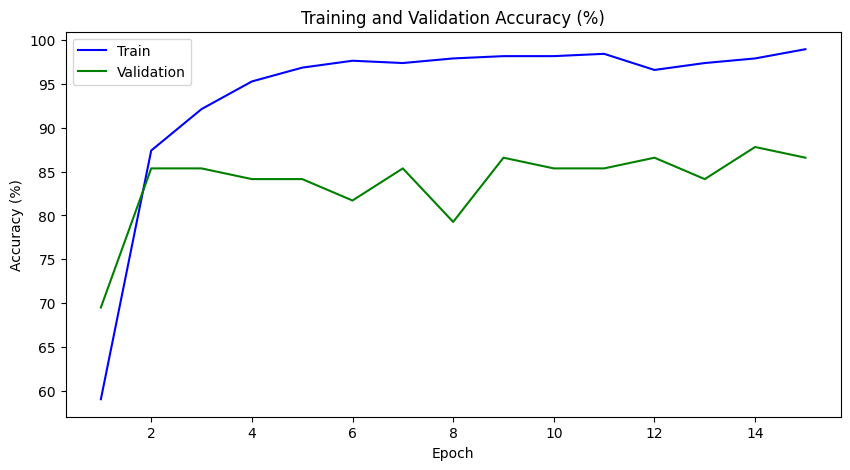

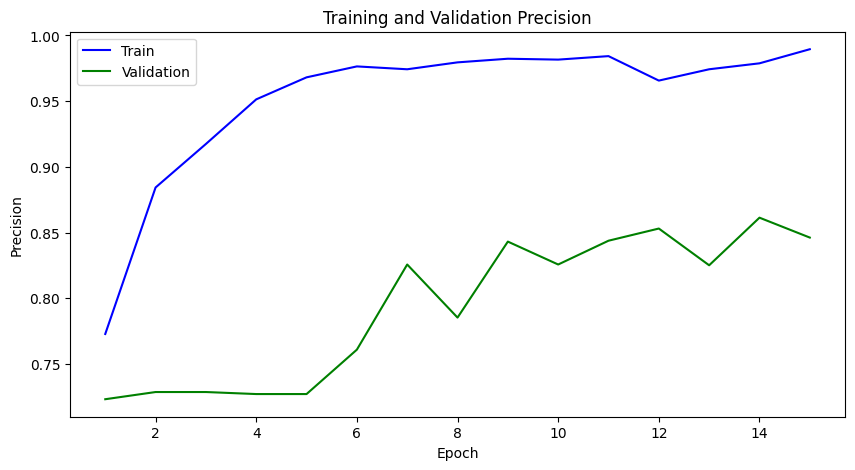

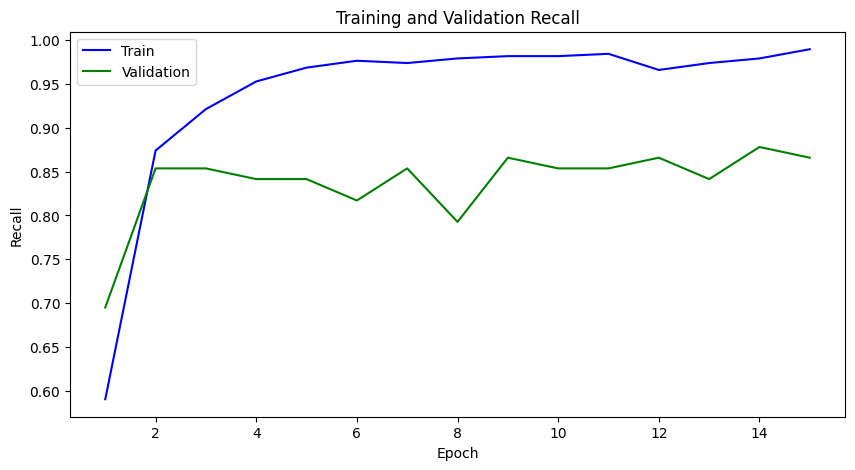

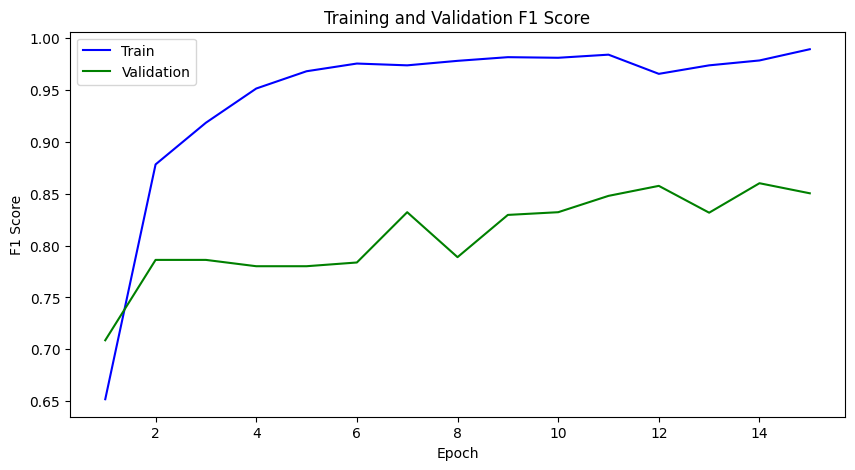

In [34]:
train_model_with_metrics_tqdm(model_resnet,train_loader, valid_loader, criterion_restnet, optimizer_restnet, num_epochs=15)

## Output Prediction


📊 Results for: Intial Model
   Accuracy  : 86.59%
   Precision : 0.7497
   Recall    : 0.8659
   F1 Score  : 0.8036
   Classification Report:
              precision    recall  f1-score   support

 Defect_free       0.00      0.00      0.00        11
     Stained       0.87      1.00      0.93        71

    accuracy                           0.87        82
   macro avg       0.43      0.50      0.46        82
weighted avg       0.75      0.87      0.80        82



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


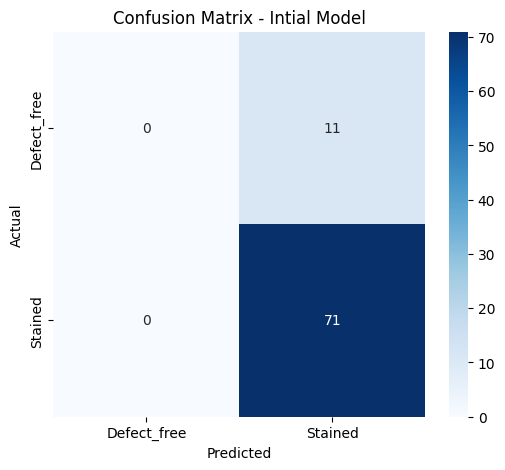


🧠 Grad-CAM Visualizations for Intial Model


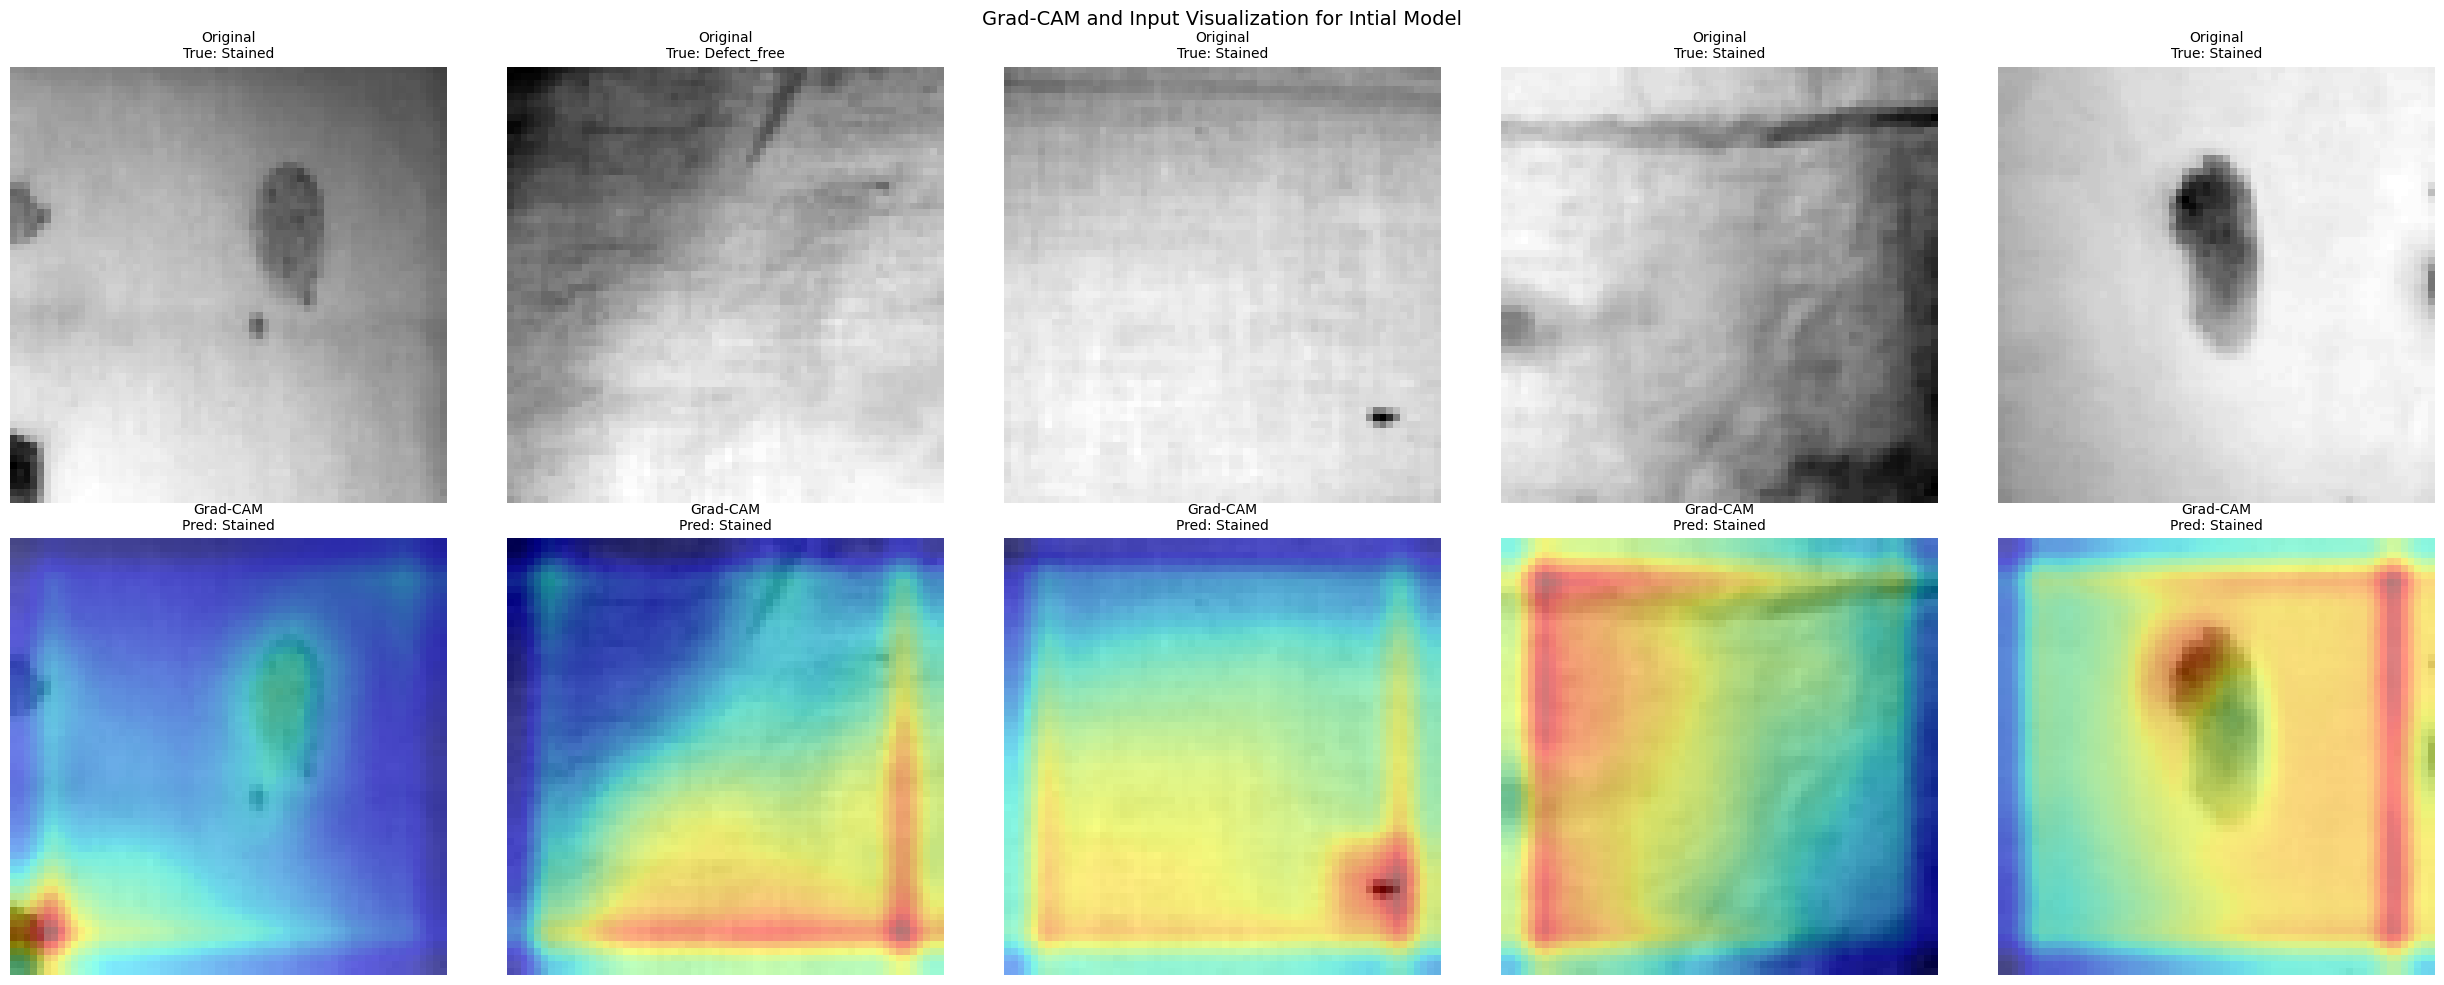


📊 Results for: Improved CNN
   Accuracy  : 29.27%
   Precision : 0.8872
   Recall    : 0.2927
   F1 Score  : 0.3049
   Classification Report:
              precision    recall  f1-score   support

 Defect_free       0.16      1.00      0.28        11
     Stained       1.00      0.18      0.31        71

    accuracy                           0.29        82
   macro avg       0.58      0.59      0.29        82
weighted avg       0.89      0.29      0.30        82



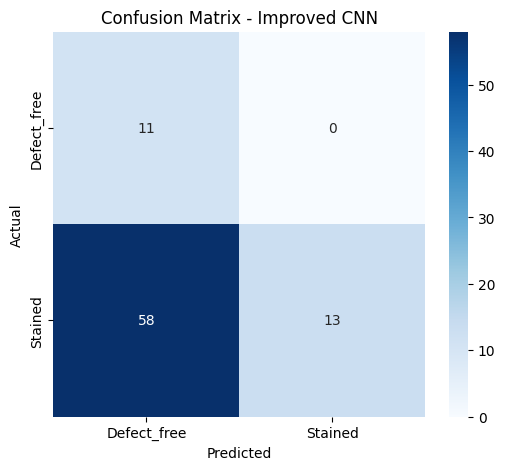


🧠 Grad-CAM Visualizations for Improved CNN


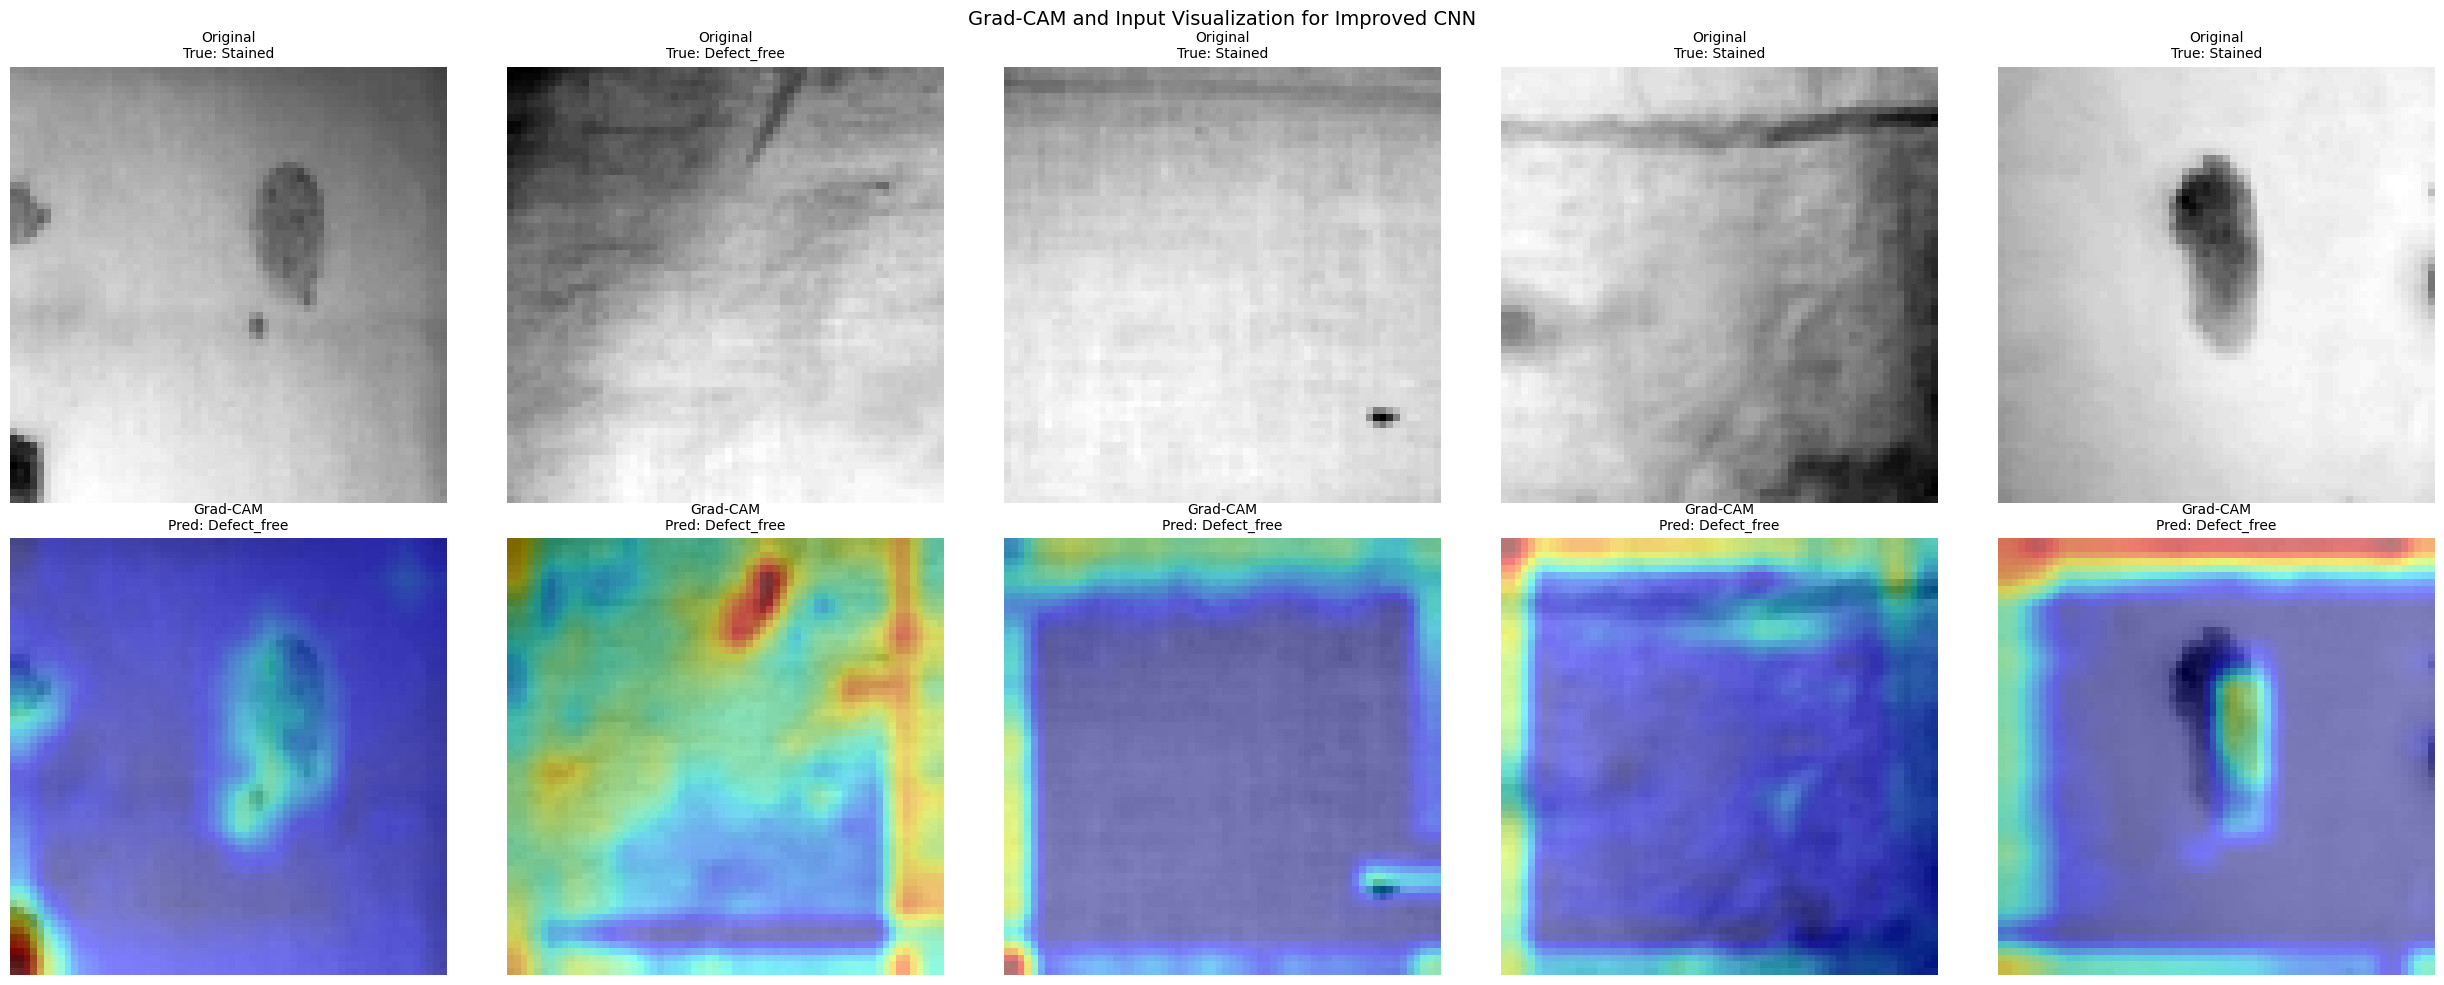


📊 Results for: ResNet18
   Accuracy  : 86.59%
   Precision : 0.8510
   Recall    : 0.8659
   F1 Score  : 0.8567
   Classification Report:
              precision    recall  f1-score   support

 Defect_free       0.50      0.36      0.42        11
     Stained       0.91      0.94      0.92        71

    accuracy                           0.87        82
   macro avg       0.70      0.65      0.67        82
weighted avg       0.85      0.87      0.86        82



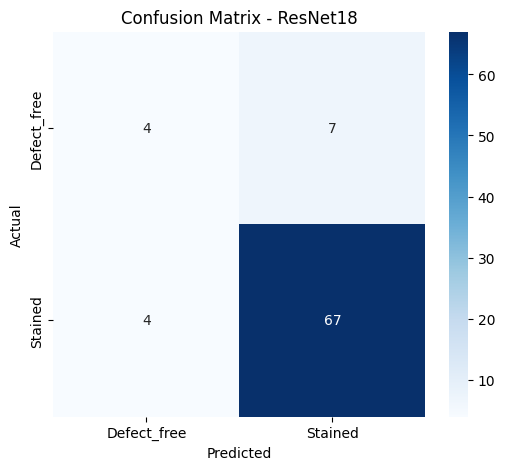


🧠 Grad-CAM Visualizations for ResNet18


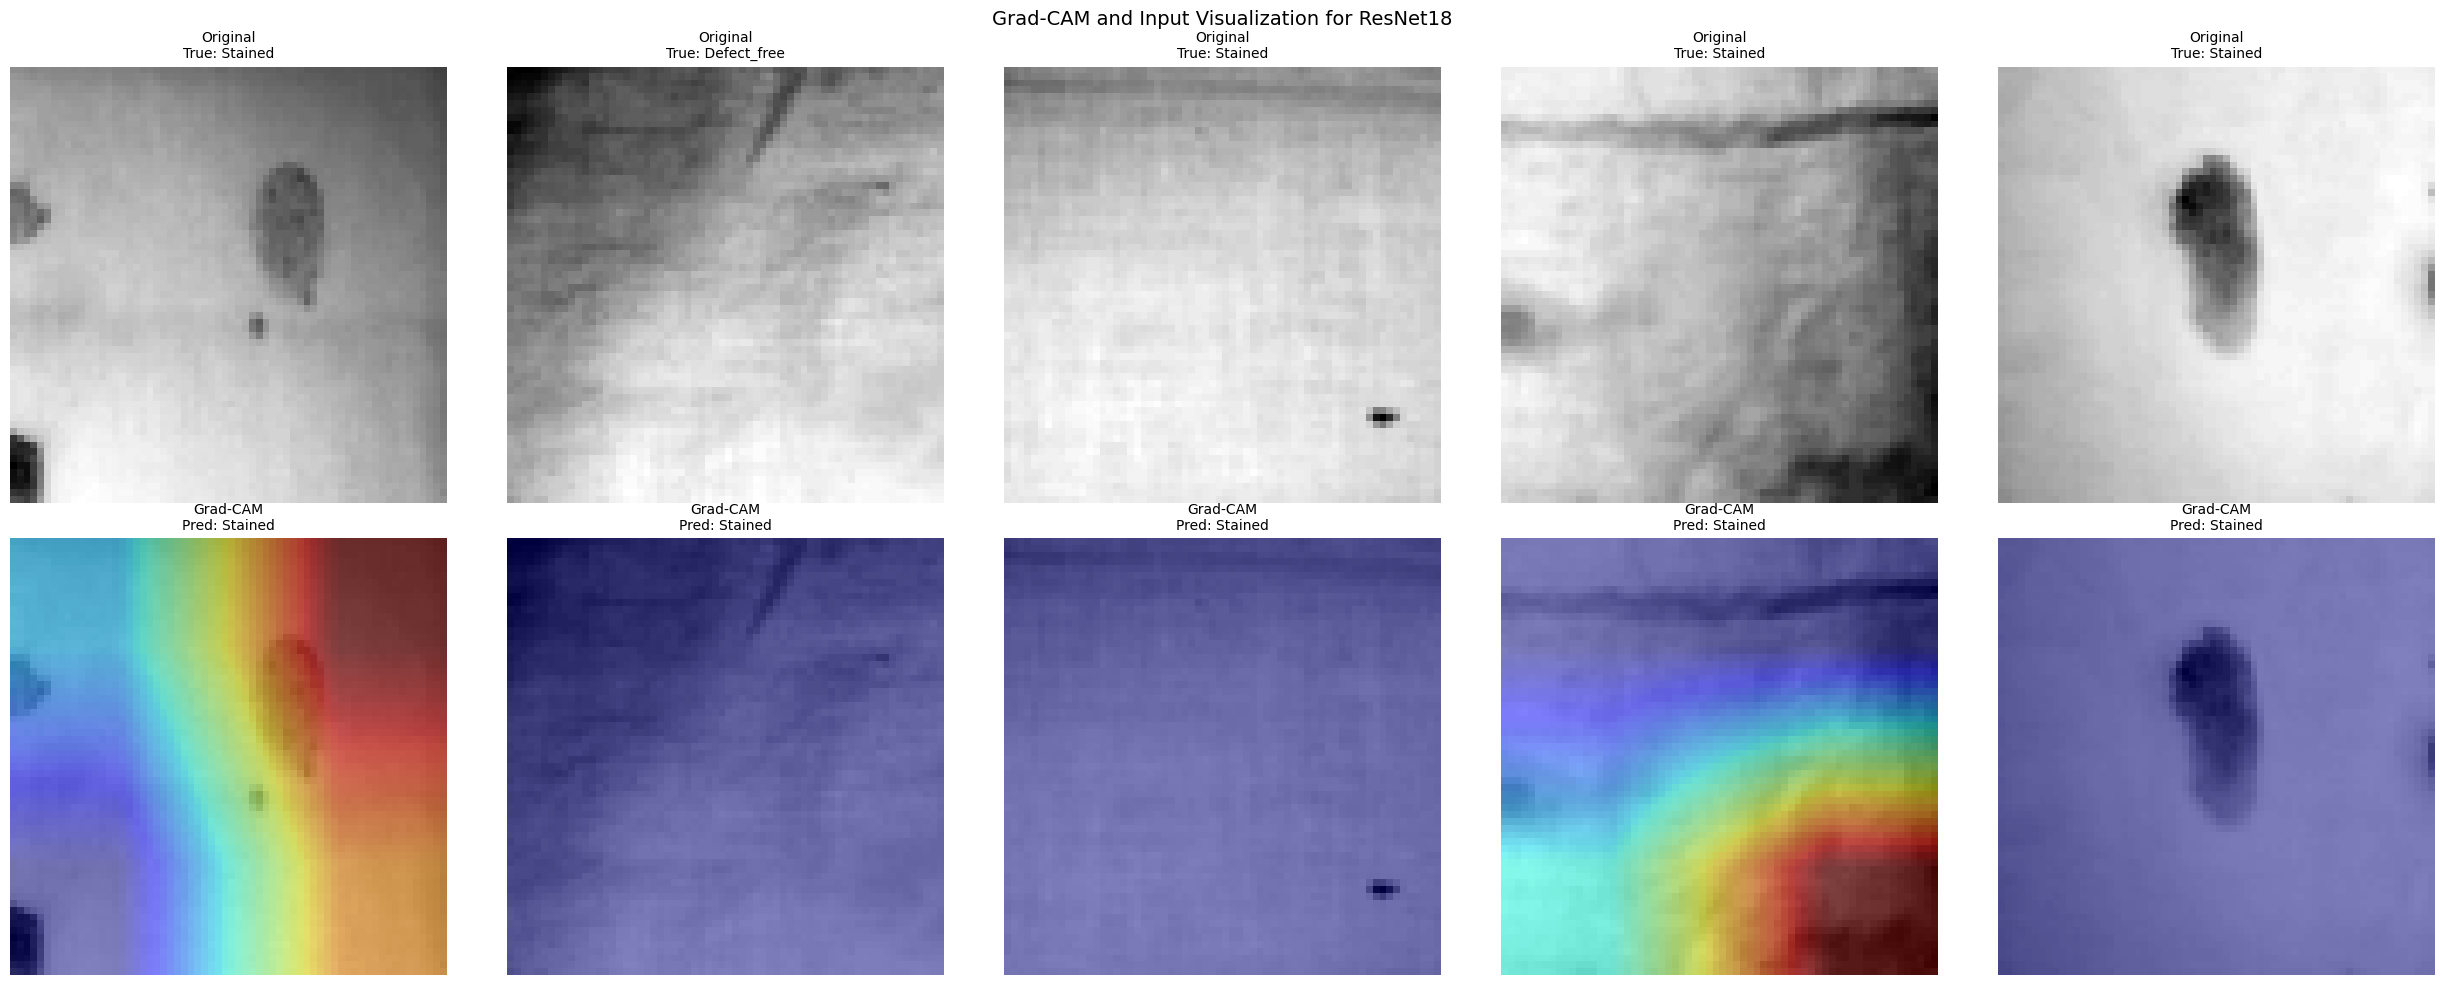


📊 Results for: EfficientNetB0
   Accuracy  : 85.37%
   Precision : 0.8424
   Recall    : 0.8537
   F1 Score  : 0.8474
   Classification Report:
              precision    recall  f1-score   support

 Defect_free       0.44      0.36      0.40        11
     Stained       0.90      0.93      0.92        71

    accuracy                           0.85        82
   macro avg       0.67      0.65      0.66        82
weighted avg       0.84      0.85      0.85        82



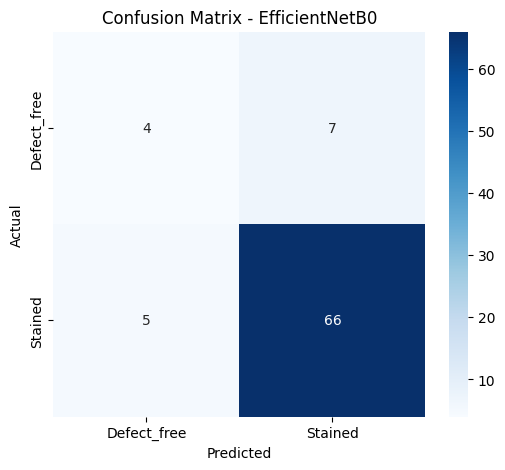


🧠 Grad-CAM Visualizations for EfficientNetB0


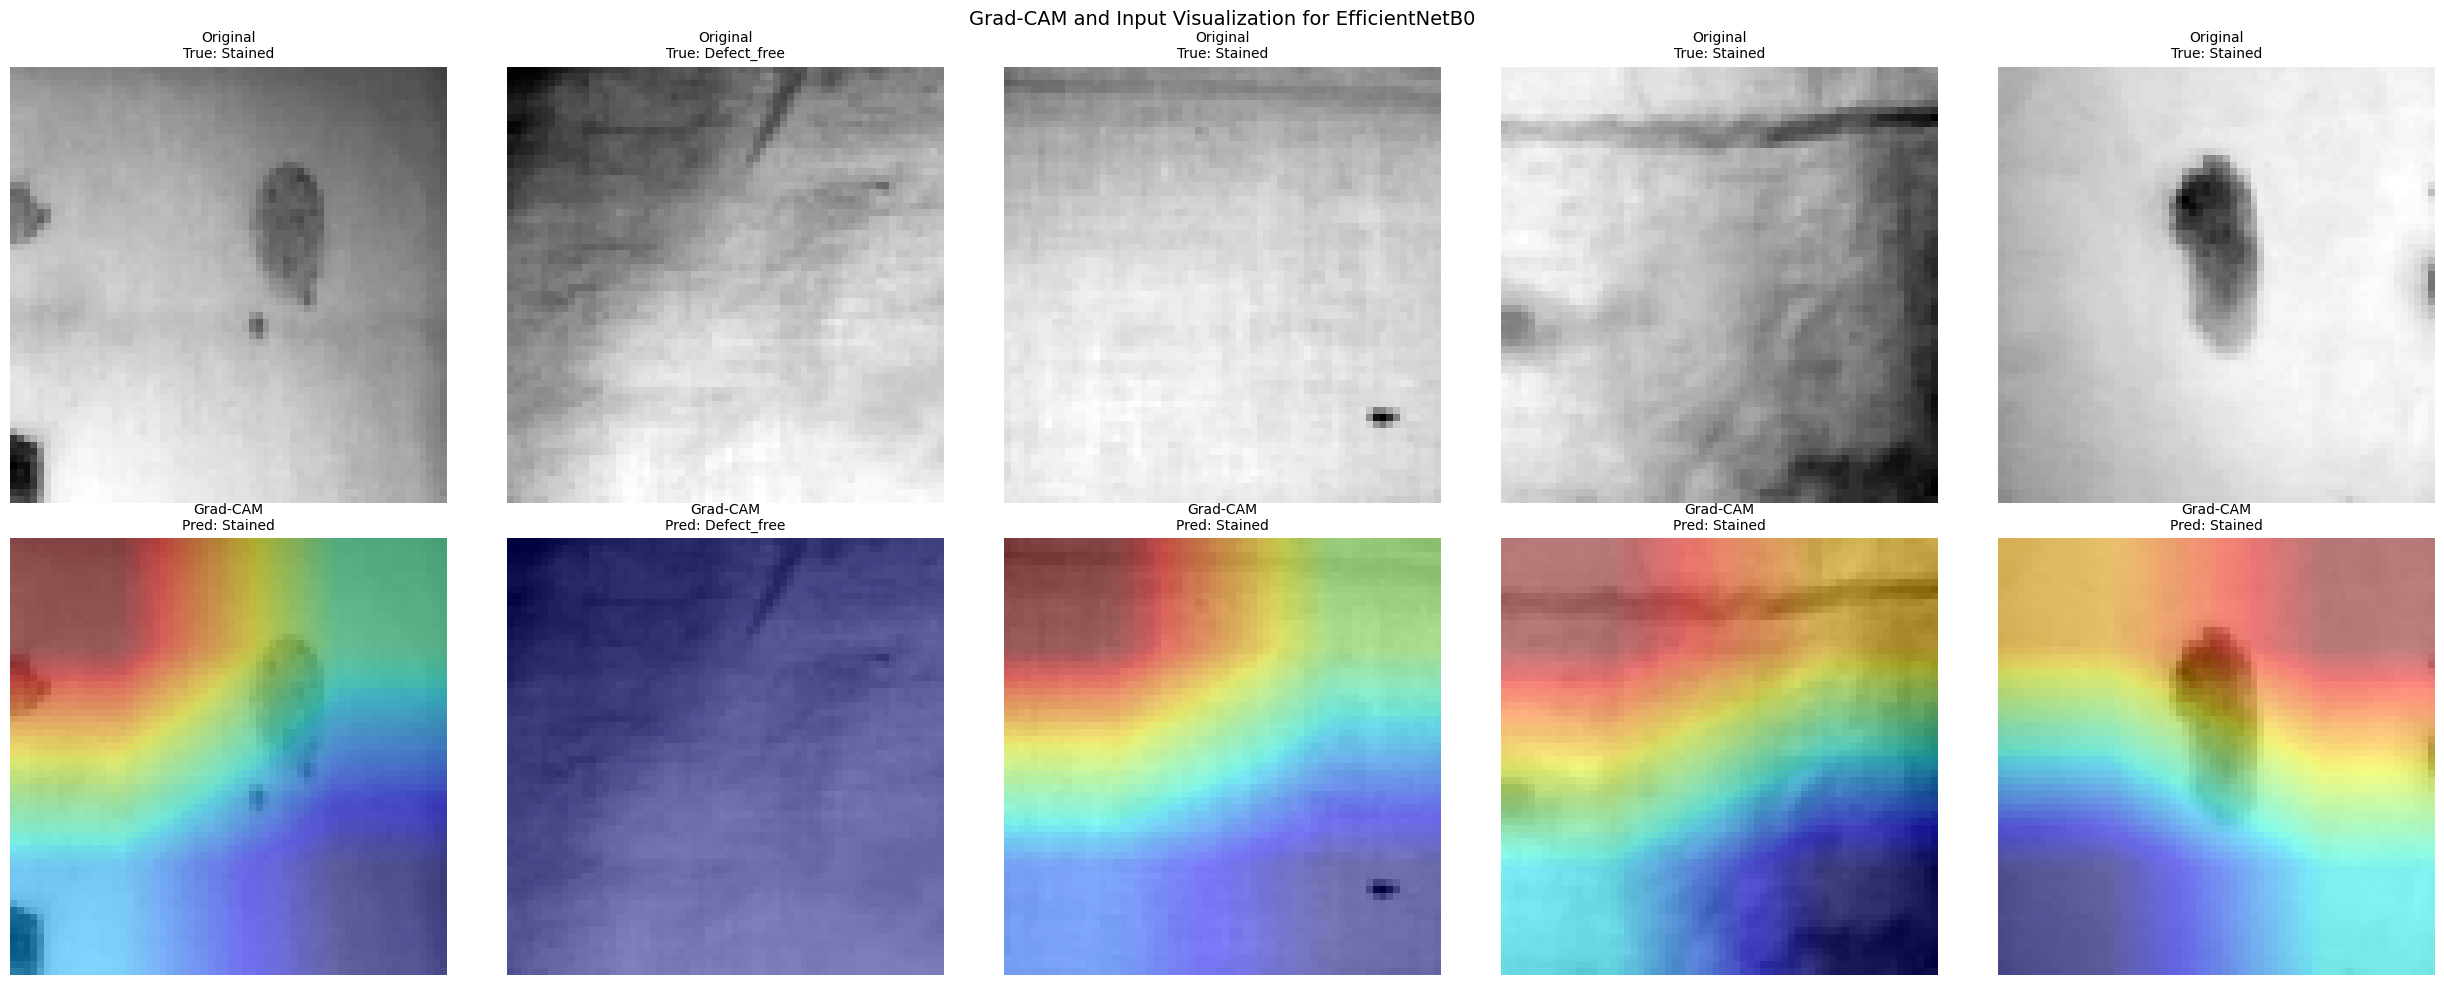


📊 Results for: tuned
   Accuracy  : 75.61%
   Precision : 0.8332
   Recall    : 0.7561
   F1 Score  : 0.7850
   Classification Report:
              precision    recall  f1-score   support

 Defect_free       0.29      0.55      0.38        11
     Stained       0.92      0.79      0.85        71

    accuracy                           0.76        82
   macro avg       0.60      0.67      0.61        82
weighted avg       0.83      0.76      0.78        82



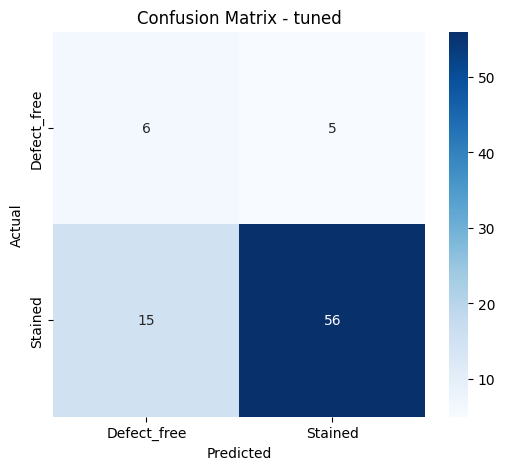


🧠 Grad-CAM Visualizations for tuned


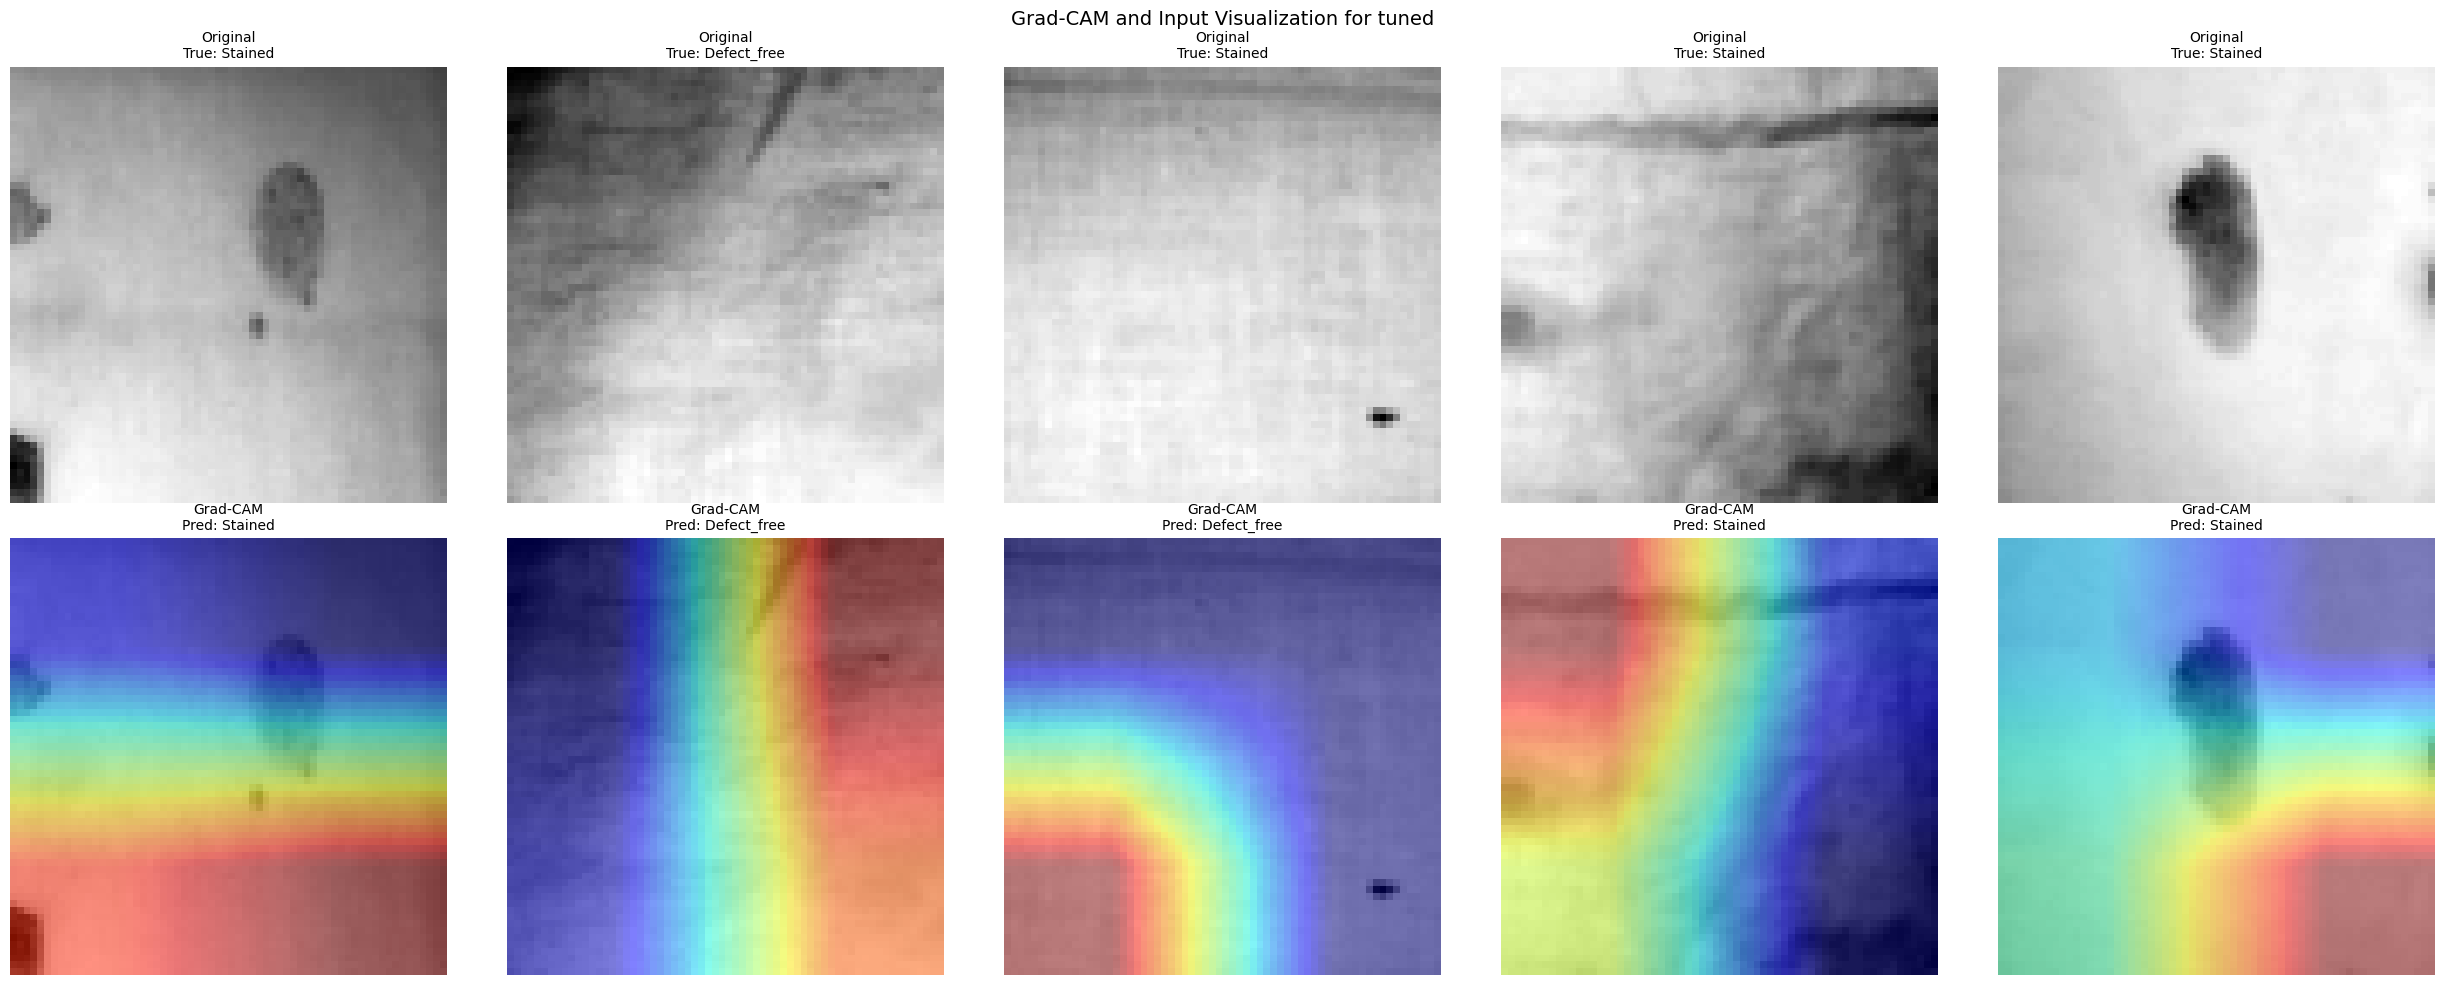

In [36]:
all_models = [model_intial_model,model_improved, model_resnet, model_efficient,model_efficient_tuned]
model_names = ['Intial Model','Improved CNN', 'ResNet18', 'EfficientNetB0','tuned']
class_names = ['Defect_free', 'Stained']

evaluate_multiple_models_with_gradcam(all_models, model_names, test_loader, class_names, num_samples=5)


# Model Saving

In [ ]:
ls

cnn_model.onnx  i_cnn_model.onnx  stained/  stain_free/


In [ ]:
torch.save(model_intial_model.state_dict(), "cnn_model.pth")
torch.save(model_improved.state_dict(), "improved_cnn.pth")
torch.save(model_efficient.state_dict(), "efficientnet_model.pth")
torch.save(model_resnet.state_dict(), "resnet_model.pth")
torch.save(model_efficient_tuned.state_dict(), "efficientnet_model_tuned.pth")

In [ ]:
from google.colab import files
files.download("cnn_model.pth")
files.download("improved_cnn.pth")
files.download("efficientnet_model.pth")
files.download("resnet_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving t.jfif to t.jfif


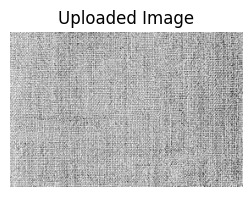

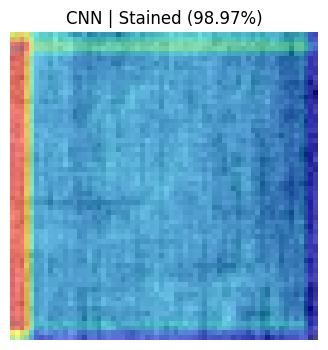

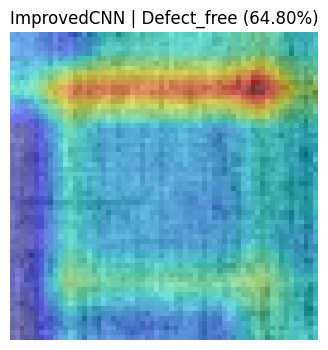

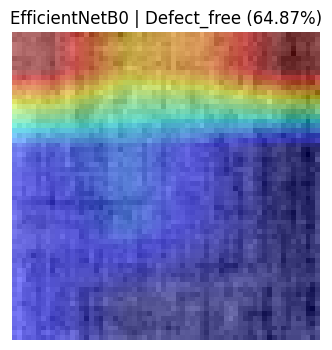

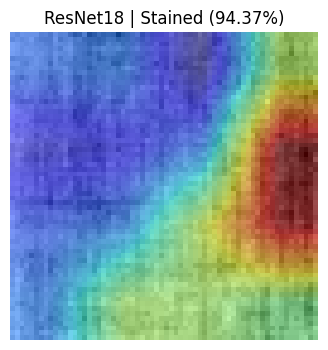

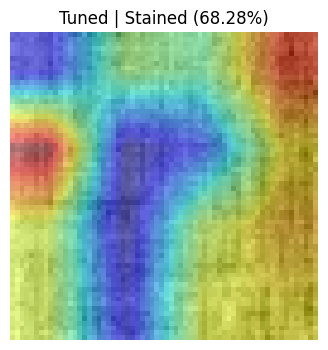

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# --- Upload and show input image ---
uploaded = files.upload()
image_path = next(iter(uploaded))

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
image = Image.open(image_path).convert('L')
input_tensor = transform(image).unsqueeze(0)

plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.title("Uploaded Image")
plt.axis('off')
plt.show()

# --- Class labels ---
class_labels = ['Defect_free', 'Stained']

# --- Model Definitions ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.view(x.size(0), -1).size(1), 512).to(x.device)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)

        self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.5)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)
        self._init_weights()

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.dropout2(x)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = F.leaky_relu(self.bn6(self.conv6(x)))
        x = self.dropout3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def efficientnet_model(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def build_resnet18_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def efficientnet_model_finetune(num_classes=2, unfreeze_from_block=4):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Adapt to grayscale input
    model.features[0][0] = nn.Conv2d(
        in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False
    )

    # Freeze all layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Unfreeze from selected block
    for name, module in model.features.named_children():
        if int(name) >= unfreeze_from_block:
            for param in module.parameters():
                param.requires_grad = True

    # Replace classification head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )

    return model


# --- Grad-CAM Utility ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        self.hook_handles.append(
            self.target_layer.register_forward_hook(lambda m, i, o: setattr(self, 'activations', o))
        )
        self.hook_handles.append(
            self.target_layer.register_full_backward_hook(lambda m, gin, gout: setattr(self, 'gradients', gout[0]))
        )

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.detach().cpu().numpy()

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

# --- Show Grad-CAM Overlay ---
def show_cam_on_image(img_tensor, cam, title=""):
    cam_resized = Image.fromarray(np.uint8(cam * 255)).resize((64, 64), resample=Image.BILINEAR)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_tensor.squeeze().numpy(), cmap='gray')
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Models Info ---
models_info = {
    "CNN": {
        "model": CNN(),
        "path": "cnn_model.pth",
        "get_target_layer": lambda m: m.conv2
    },
    "ImprovedCNN": {
        "model": ImprovedCNN(),
        "path": "improved_cnn.pth",
        "get_target_layer": lambda m: m.conv4
    },
    "EfficientNetB0": {
        "model": efficientnet_model(),
        "path": "efficientnet_model.pth",
        "get_target_layer": lambda m: m.features[4][0]
    },
    "ResNet18": {
        "model": build_resnet18_model(),
        "path": "resnet_model.pth",
        "get_target_layer": lambda m: m.layer3[1].conv2
    },
    "Tuned": {
        "model": efficientnet_model_finetune(),
        "path": "efficientnet_model_tuned.pth",
        "get_target_layer": lambda m: m.features[4][0]
    }
}

# --- Run Prediction + Grad-CAM ---
for name, info in models_info.items():
    model = info["model"]

    if name == "CNN":
        _ = model(input_tensor)

    model.load_state_dict(torch.load(info["path"], map_location="cpu"))
    model.eval()

    target_layer = info["get_target_layer"](model)
    cam_generator = GradCAM(model, target_layer)
    cam = cam_generator.generate(input_tensor)
    cam_generator.remove_hooks()

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_label = class_labels[pred_idx]
        confidence = probs[0, pred_idx].item()

    title = f"{name} | {pred_label} ({confidence:.2%})"
    show_cam_on_image(input_tensor, cam, title=title)
